
# Executive Summary

The best predictors in the dataset are a combinatio of Overall, Potential and Age.

However these are derived metrics, non interpretable and abstract, "buy the best overall" "buy the most potential" are not actionable steps.

Analysis decomposes these measures into their base components to derive what truly drives valuation and how value can be increased.

# **Valuing Outfielders**

### **1. Core Valuation Model**

1. There is a subset of highly valuable players, archetypes emerge in this group, the ideal attacking profile and the ideal defensive profile.

2. Pricing can be largely attributed to distance from these market ideals

3. Closing that gap is how clubs can generate value from player development

 **this framework provides**
 - clear reasons for a players current value *(descriptive)*
 - clear ways to increase a players current value *(prescriptive)*
 - Is repeatable year on year as the game evolves the core analytical framework can be redeployed to generate new descriptive and prescritive findings


### **2. Offensive Premiums**

**In this cycle there is an estimated 256 million euro upside from targeted development programs.**

1. The current market ideal is shaped by strong technical skills (dribbling, passing, shooting). 

2. Marginal gains on this offensive bundle have disproportionate premiums on valuation.

3. These premiums are convex, the closer a player moves to the "ideal" the stronger the marginal premiums become.




# EDA

- This notebook is the bulk of analysis, please see processing for cleaning etc
- Brief of that notebook is that missingness is highly informative, the initial players dataset is divided into a GK and outfield dataset
- and that players with tags, players who have nicknames and archetpyes are worth on average 4x more than their non tagged counterparts.

This EDA examines why are these players worth so much, what principles here can be taken to general valuation?

In [202]:
import pandas as pd

# Load processed datasets
outfield_df = pd.read_csv("../data/outfield_players.csv")
gk_df = pd.read_csv("../data/gk_players.csv")

# Quick sanity checks
outfield_df.shape, gk_df.shape
outfield_df.head()
outfield_df.columns

Index(['Unnamed: 0', 'sofifa_id', 'short_name', 'overall', 'potential', 'age',
       'height_cm', 'weight_kg', 'club_name', 'league_name',
       'club_contract_valid_until', 'preferred_foot', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'formation',
       'player_tags', 'value_eur', 'is_star'],
      dtype='object')

In [221]:
#based on our eda, we know a handful of features have extremely high correlations with the target, a baseline model will attempt to predict using these features only.

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

df = outfield_df[["overall", "potential", "age", "value_eur"]].dropna()
df = df[df["value_eur"] > 0]

df["log_value"] = np.log10(df["value_eur"])

X = df[["overall", "potential", "age"]]
y = df["log_value"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

results = pd.DataFrame({
    "model": ["Linear regression", "Random forest"],
    "r2": [
        r2_score(y_test, y_pred_lin),
        r2_score(y_test, y_pred_rf)
    ],
    "mae_log_eur": [
        mean_absolute_error(y_test, y_pred_lin),
        mean_absolute_error(y_test, y_pred_rf)
    ]
})

results


model        r2  mae_log_eur
0  Linear regression  0.964778     0.070112
1      Random forest  0.981032     0.050726

# **Overall & Age & Potential EXPLAIN PRETTY MUCH EVERYTHING** 
***(but thats useless)***

- A simple baseline model using **Overall + Age + Potential** explains player market value almost perfectly: **~96% R² (linear regression)** and **~98% R² (nonlinear / random forest)**, with the nonlinear uplift coming from capturing **interactions and thresholds**.

- This does **not** translate into an actionable strategy, because **Overall is an opaque, handcrafted composite** that already embeds expert scouting judgement, reputation, and performance signals; “Overall predicts value” is effectively tautological and does not tell you what to *do*.

- Because the strongest predictor is a black-box aggregate, the real objective is **decomposition**: identify the underlying **skill bundles and archetypes** that create elite pricing—especially in a market with extreme value concentration—so decisions can be made on **trainable traits** rather than a single summary score.



### **MECE Segmentation**

- Players are currently segmented into **goalkeepers**, **outfield players**, and **outfield stars**, with outfield players further grouped into **defenders, midfielders, and attackers**.

- While useful for broad comparisons, these categories remain **structurally coarse** and may mask meaningful heterogeneity in how the market prices different player profiles.

- This stage of EDA investigates whether **hidden structure exists within outfield stars**, using clustering methods to identify statistically distinct skill archetypes beyond traditional position labels.


### **Clustering the Stars**

In [ ]:

# Exploratory clustering of STAR outfield players (loaded data)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Subset: star outfield players
star_df = outfield_df[outfield_df["is_star"] == 1].copy()

# Features for loose, exploratory clustering
features = [
    
    "height_cm",
    "weight_kg",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
]

# Drop rows with missing values in clustering features
X = star_df[features].dropna()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Silhouette sweep to find cleanest separation
sil_scores = {}

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

sil_scores

# Select best k
best_k = max(sil_scores, key=sil_scores.get)
best_k

# Fit final KMeans
kmeans = KMeans(n_clusters=best_k, random_state=420, n_init=20)
clusters = kmeans.fit_predict(X_scaled)

# Attach cluster labels back to star_df
star_df.loc[X.index, "cluster"] = clusters

# Cluster sizes
star_df["cluster"].value_counts()

# Cluster profiles (raw means)
cluster_means = (
    star_df
    .groupby("cluster")[features]
    .mean()
    .round(2)
)

cluster_means


height_cm  weight_kg   pace  shooting  passing  dribbling  defending  \
cluster                                                                         
0.0         176.68      71.94  80.22     69.43    70.66      77.07      51.87   
1.0         190.21      86.30  56.73     49.83    54.88      57.36      62.87   

         physic  
cluster          
0.0       68.88  
1.0       79.74

In [ ]:
# Crosstab: counts
print("CLUSTER vs POSITION: Counts")
print(pd.crosstab(star_df['formation'], star_df['cluster'], margins=True))

# Crosstab: percentages by row (position)
print("\n" + "=" * 60)
print("CLUSTER vs POSITION: Row Percentages")

print(pd.crosstab(star_df['formation'], star_df['cluster'], normalize='index').round(3) * 100)

CLUSTER vs POSITION: Counts
cluster    0.0  1.0  All
formation               
att        164   61  225
def         69  170  239
mid        217   29  246
All        450  260  710

CLUSTER vs POSITION: Row Percentages
cluster     0.0   1.0
formation            
att        72.9  27.1
def        28.9  71.1
mid        88.2  11.8


In [157]:
star_df.groupby("cluster")["value_eur"].agg(["count", "mean", "median"])


count          mean     median
cluster                                
0.0        343  1.588112e+07  4900000.0
1.0        241  5.547863e+06  1900000.0

Even within stars there is a value hierarchy

Defensive Vs Offensive STARS
offensive stars are valued more strongly

Further skill details in tags


In [208]:
# Sample players with their tags from each cluster
for c in sorted(star_df["cluster"].dropna().unique()):
    print(f"\nCluster {int(c)} — sample players (name + tags):")
    
    sample_df = (
        star_df[star_df["cluster"] == c][["short_name", "player_tags"]]
        .dropna(subset=["player_tags"])
        .sample(10, random_state=42)
    )
    
    display(sample_df)



Cluster 0 — sample players (name + tags):


short_name                                        player_tags
4970        J. Murillo                               #Speedster, #Acrobat
5367     M. Arnautović                                          #Strength
2056           R. Falk                                           #Acrobat
383            J. Holt                                           #Acrobat
5064  Matheus Bardeira  #Aerial Threat, #Clinical Finisher, #Complete ...
2330          M. Cuero                                         #Speedster
4431          J. Cabot                                         #Speedster
5388    R. Lewandowski  #Aerial Threat, #Distance Shooter, #Clinical F...
3828         J. McGinn                                            #Engine
4133      J. Toornstra                                            #Engine


Cluster 1 — sample players (name + tags):


short_name                  player_tags
1006      I. Armaș                    #Strength
3604   M. Škriniar                  #Tactician 
5092    T. Pekhart    #Aerial Threat, #Strength
3624     T. Parker                    #Strength
4699  J. Bergström                    #Strength
5413      T. Jurić                    #Strength
3545      J. Matip  #Aerial Threat, #Tactician 
3290     S. Taylor                    #Strength
300      I. Traoré                    #Strength
3576   Raúl Albiol       #Tackling, #Tactician

In [211]:
# Identify which cluster is offensive vs defensive
if cluster_means.loc[0, 'defending'] > cluster_means.loc[1, 'defending']:
    defensive_cluster, offensive_cluster = 0, 1
else:
    defensive_cluster, offensive_cluster = 1, 0

print(f"Offensive cluster: {offensive_cluster}")
print(f"Defensive cluster: {defensive_cluster}")

# Compare values within elite group
off_stars = star_df[star_df['cluster'] == offensive_cluster]['value_eur']
def_stars = star_df[star_df['cluster'] == defensive_cluster]['value_eur']

print(f"\n{'='*60}")
print("ELITE PLAYER VALUATION BY ARCHETYPE")
print('='*60)

print(f"\nOffensive stars (n={len(off_stars)}):")
print(f"  Median: €{off_stars.median()/1e6:.1f}M")
print(f"  Mean:   €{off_stars.mean()/1e6:.1f}M")

print(f"\nDefensive stars (n={len(def_stars)}):")
print(f"  Median: €{def_stars.median()/1e6:.1f}M")
print(f"  Mean:   €{def_stars.mean()/1e6:.1f}M")

print(f"\n{'='*60}")
print("THE OFFENSIVE PREMIUM")
print('='*60)
print(f"Median ratio:  {off_stars.median() / def_stars.median():.2f}x")
print(f"Median gap:    €{(off_stars.median() - def_stars.median())/1e6:.1f}M")
print(f"Mean ratio:    {off_stars.mean() / def_stars.mean():.2f}x")
print(f"Mean gap:      €{(off_stars.mean() - def_stars.mean())/1e6:.1f}M")

# Statistical test
from scipy.stats import mannwhitneyu, ttest_ind

stat, p_mw = mannwhitneyu(off_stars, def_stars, alternative='greater')
t_stat, p_t = ttest_ind(off_stars, def_stars)

print(f"\n{'='*60}")
print("STATISTICAL TESTS")
print('='*60)
print(f"Mann-Whitney U (offensive > defensive): p = {p_mw:.2e}")
print(f"T-test (two-sided):                     p = {p_t:.2e}")

# Age check
print(f"\n{'='*60}")
print("AGE CHECK (potential confounder)")
print('='*60)
off_age = star_df[star_df['cluster'] == offensive_cluster]['age']
def_age = star_df[star_df['cluster'] == defensive_cluster]['age']
print(f"Offensive stars mean age: {off_age.mean():.1f}")
print(f"Defensive stars mean age: {def_age.mean():.1f}")

# Position mix check using 'formation' column
print(f"\n{'='*60}")
print("POSITION MIX CHECK (potential confounder)")
print('='*60)
print("\nOffensive cluster position mix:")
print(star_df[star_df['cluster'] == offensive_cluster]['formation'].value_counts())
print("\nDefensive cluster position mix:")
print(star_df[star_df['cluster'] == defensive_cluster]['formation'].value_counts())

# Bonus: compare within same position group
print(f"\n{'='*60}")
print("WITHIN-POSITION COMPARISON (controls for position)")
print('='*60)

for pos in star_df['formation'].dropna().unique():
    pos_off = star_df[(star_df['cluster'] == offensive_cluster) & (star_df['formation'] == pos)]['value_eur']
    pos_def = star_df[(star_df['cluster'] == defensive_cluster) & (star_df['formation'] == pos)]['value_eur']
    
    if len(pos_off) >= 5 and len(pos_def) >= 5:
        print(f"\n{pos.upper()}:")
        print(f"  Offensive (n={len(pos_off)}): median €{pos_off.median()/1e6:.1f}M")
        print(f"  Defensive (n={len(pos_def)}): median €{pos_def.median()/1e6:.1f}M")
        if pos_def.median() > 0:
            print(f"  Ratio: {pos_off.median() / pos_def.median():.2f}x")
    else:
        print(f"\n{pos.upper()}: insufficient data (off={len(pos_off)}, def={len(pos_def)})")

Offensive cluster: 0
Defensive cluster: 1

ELITE PLAYER VALUATION BY ARCHETYPE

Offensive stars (n=450):
  Median: €4.9M
  Mean:   €15.9M

Defensive stars (n=260):
  Median: €1.9M
  Mean:   €5.5M

THE OFFENSIVE PREMIUM
Median ratio:  2.58x
Median gap:    €3.0M
Mean ratio:    2.86x
Mean gap:      €10.3M

STATISTICAL TESTS
Mann-Whitney U (offensive > defensive): p = nan
T-test (two-sided):                     p = nan

AGE CHECK (potential confounder)
Offensive stars mean age: 26.9
Defensive stars mean age: 28.4

POSITION MIX CHECK (potential confounder)

Offensive cluster position mix:
formation
mid    217
att    164
def     69
Name: count, dtype: int64

Defensive cluster position mix:
formation
def    170
att     61
mid     29
Name: count, dtype: int64

WITHIN-POSITION COMPARISON (controls for position)

MID:
  Offensive (n=217): median €5.5M
  Defensive (n=29): median €2.1M
  Ratio: 2.62x

DEF:
  Offensive (n=69): median €5.5M
  Defensive (n=170): median €1.8M
  Ratio: 3.06x

ATT:
  Of

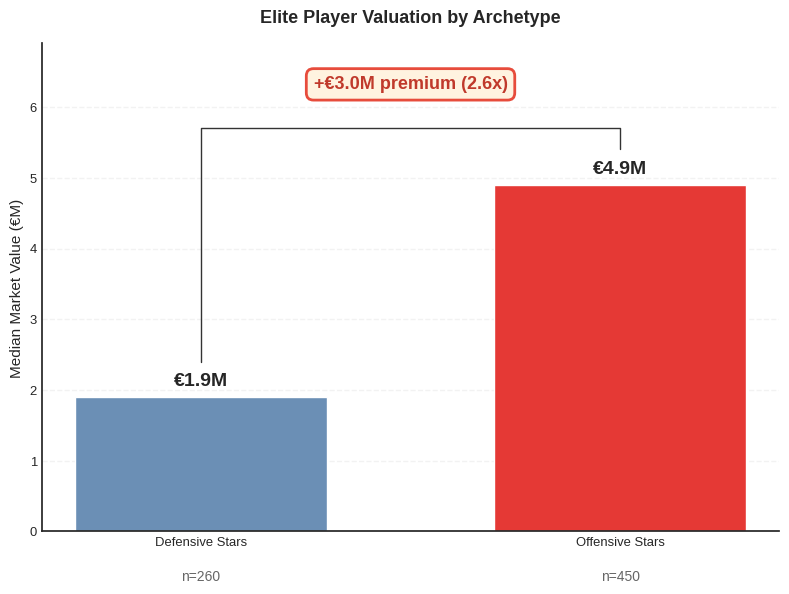

In [212]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# DATA
# ------------------------------------------------------------
groups = ["Defensive Stars", "Offensive Stars"]
median_values = [def_stars.median() / 1e6, off_stars.median() / 1e6]
premium = (off_stars.median() - def_stars.median()) / 1e6
ratio = off_stars.median() / def_stars.median()

# ------------------------------------------------------------
# PLOT
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['#6B8FB5', '#E53935']
bars = ax.bar(groups, median_values, color=colors, width=0.6)

# ------------------------------------------------------------
# VALUE LABELS ON BARS
# ------------------------------------------------------------
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.1,
        f"€{height:.1f}M",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold"
    )

# ------------------------------------------------------------
# PREMIUM BRACKET
# ------------------------------------------------------------
bracket_height = max(median_values) + 0.8

ax.plot([0, 0, 1, 1], 
        [median_values[0] + 0.5, bracket_height, bracket_height, median_values[1] + 0.5], 
        color='#333333', linewidth=1)

ax.text(
    0.5, 
    bracket_height + 0.5,
    f"+€{premium:.1f}M premium ({ratio:.1f}x)",
    ha="center",
    va="bottom",
    fontsize=13,
    fontweight="bold",
    color="#c0392b",
    bbox=dict(
        boxstyle="round,pad=0.4",
        facecolor="#fff3e0",
        edgecolor="#e74c3c",
        linewidth=2
    )
)

# ------------------------------------------------------------
# FORMATTING
# ------------------------------------------------------------
ax.set_ylabel("Median Market Value (€M)", fontsize=11)
ax.set_title("Elite Player Valuation by Archetype", fontsize=13, fontweight="bold", pad=15)
ax.set_ylim(0, bracket_height + 1.2)
ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Sample sizes with more space
ax.text(0, -0.7, f"n={len(def_stars)}", ha="center", fontsize=10, color="#666666")
ax.text(1, -0.7, f"n={len(off_stars)}", ha="center", fontsize=10, color="#666666")

plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

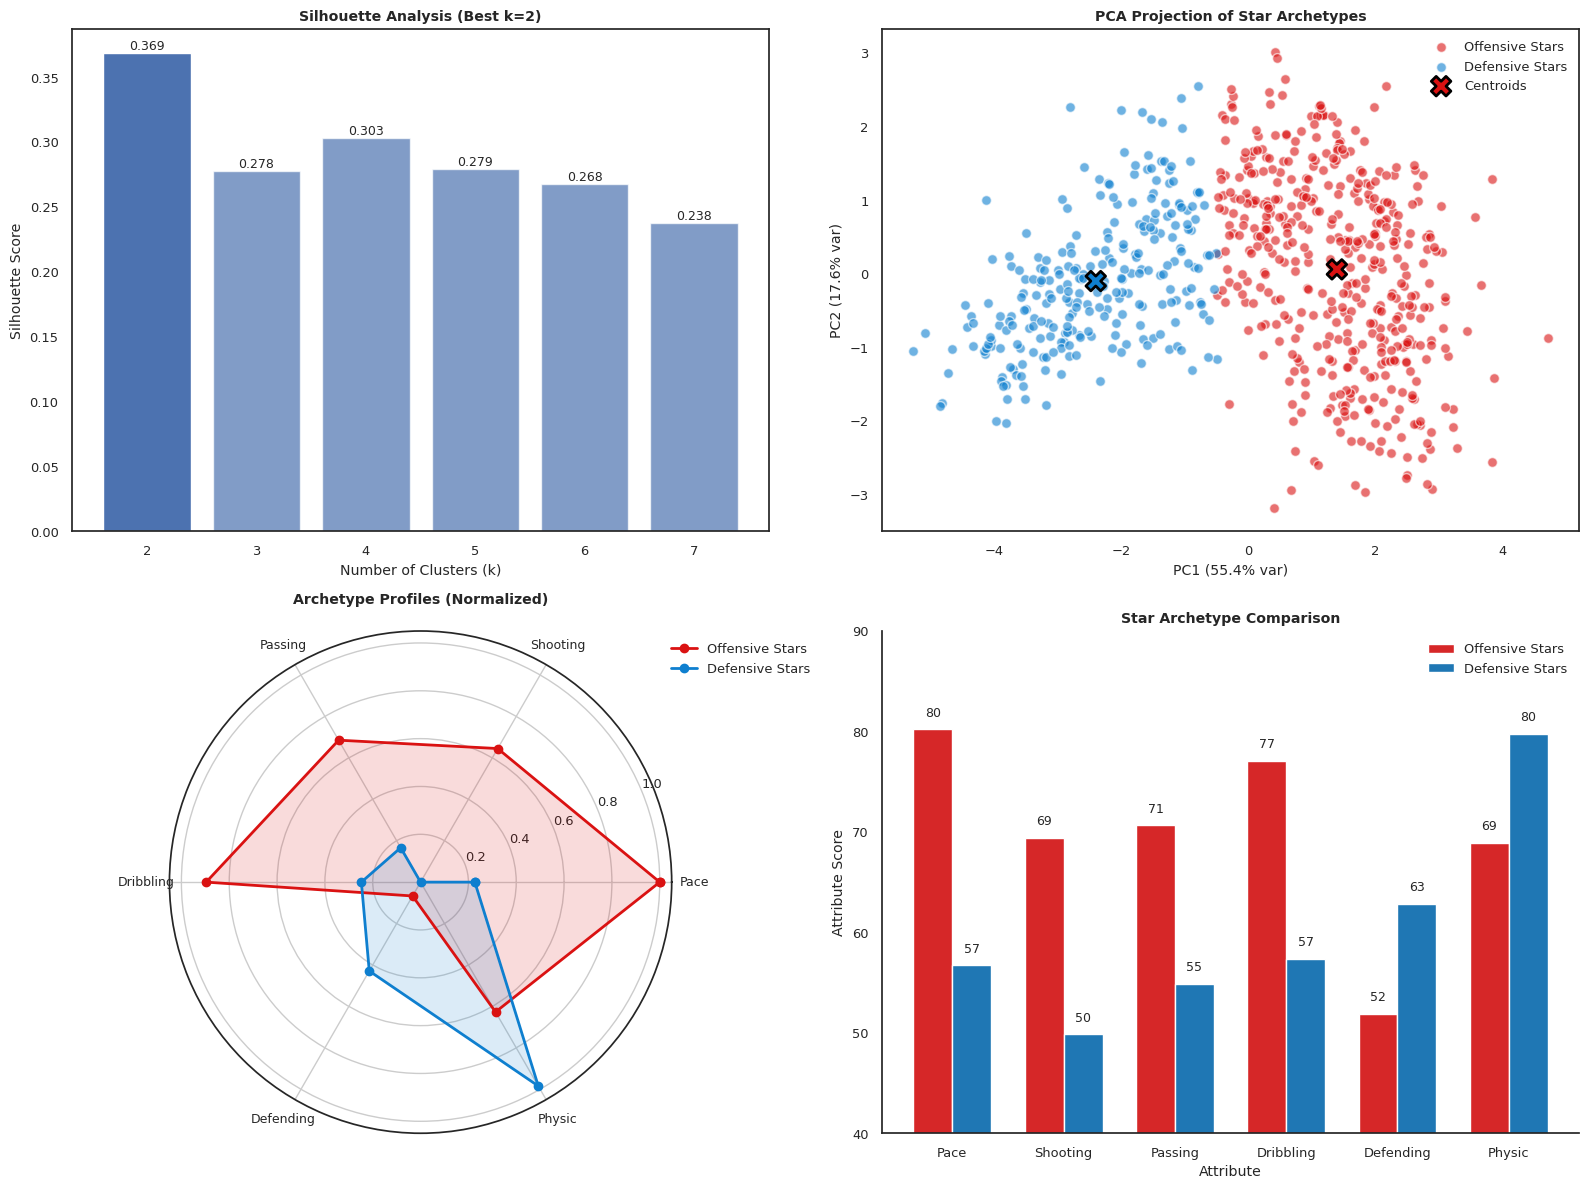

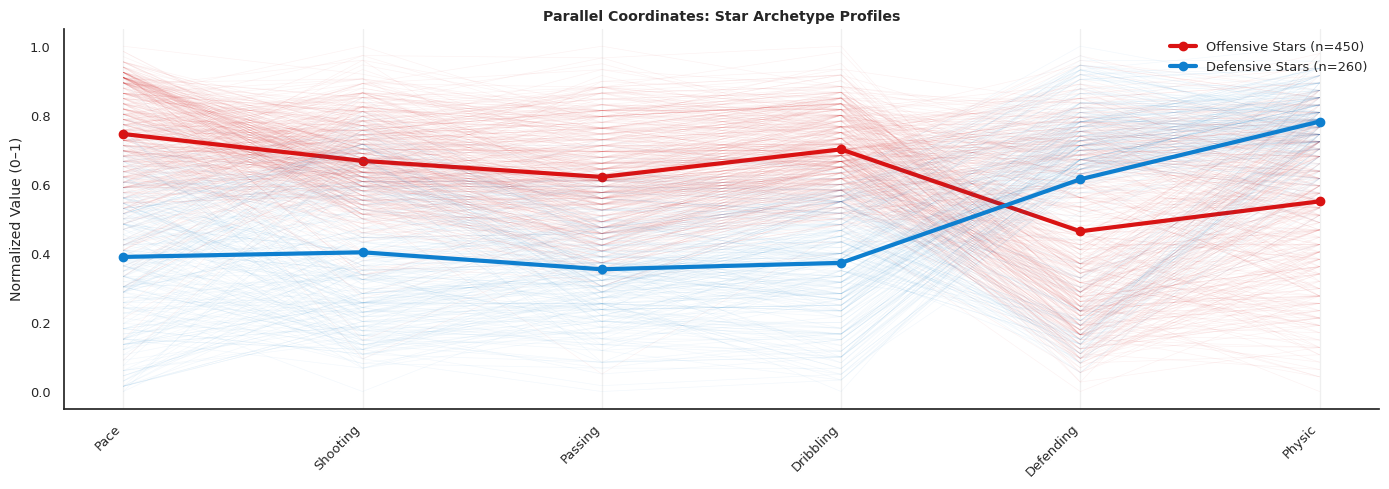

In [159]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(16, 12))

# Silhouette scores
ax1 = fig.add_subplot(2, 2, 1)

ks = list(sil_scores.keys())
scores = list(sil_scores.values())
bars = ax1.bar(ks, scores, alpha=0.7)

best_idx = ks.index(best_k)
bars[best_idx].set_alpha(1.0)

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title(f'Silhouette Analysis (Best k={best_k})', fontweight='bold')
ax1.set_xticks(ks)

for bar, score in zip(bars, scores):
    ax1.annotate(
        f'{score:.3f}',
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=9
    )

# PCA projection
ax2 = fig.add_subplot(2, 2, 2)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# FLIPPED: 0 is now Offensive (Red), 1 is now Defensive (Blue)
cluster_labels = {0: 'Offensive Stars', 1: 'Defensive Stars'}
cluster_colors = {0: "#da1212", 1: "#0e7fcf"}  # Red for offensive, Blue for defensive

for i in range(best_k):
    mask = clusters == i
    ax2.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=cluster_labels[i],
        color=cluster_colors[i],
        alpha=0.6,
        s=50,
        edgecolors='white'
    )

centroids_pca = pca.transform(kmeans.cluster_centers_)
ax2.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=200,
    c=[cluster_colors[0], cluster_colors[1]],
    edgecolors='black',
    linewidth=2,
    label='Centroids',
    zorder=5
)

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
ax2.set_title('PCA Projection of Star Archetypes', fontweight='bold')
ax2.legend()

# Radar chart
ax3 = fig.add_subplot(2, 2, 3, polar=True)

radar_features = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
cluster_means_radar = star_df.groupby('cluster')[radar_features].mean()

cluster_means_norm = (
    (cluster_means_radar - cluster_means_radar.min().min()) /
    (cluster_means_radar.max().max() - cluster_means_radar.min().min())
)

angles = np.linspace(0, 2 * np.pi, len(radar_features), endpoint=False).tolist()
angles += angles[:1]

for i in range(best_k):
    values = cluster_means_norm.loc[i].tolist()
    values += values[:1]
    ax3.plot(angles, values, 'o-', linewidth=2, label=cluster_labels[i], color=cluster_colors[i])
    ax3.fill(angles, values, alpha=0.15, color=cluster_colors[i])

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels([f.capitalize() for f in radar_features], size=9)
ax3.set_title('Archetype Profiles (Normalized)', fontweight='bold', pad=20)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Grouped bar chart (replacing heatmap)
ax4 = fig.add_subplot(2, 2, 4)

x = np.arange(len(radar_features))
width = 0.35

cluster_0_vals = cluster_means_radar.loc[0, radar_features].values  # Offensive
cluster_1_vals = cluster_means_radar.loc[1, radar_features].values  # Defensive

bars0 = ax4.bar(x - width/2, cluster_0_vals, width, label='Offensive Stars', color='#d62728')
bars1 = ax4.bar(x + width/2, cluster_1_vals, width, label='Defensive Stars', color='#1f77b4')

ax4.set_ylabel('Attribute Score')
ax4.set_xlabel('Attribute')
ax4.set_title('Star Archetype Comparison', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([f.capitalize() for f in radar_features])
ax4.legend()
ax4.set_ylim(40, 90)

for bar in bars0:
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{bar.get_height():.0f}', ha='center', va='bottom', fontsize=9)
for bar in bars1:
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{bar.get_height():.0f}', ha='center', va='bottom', fontsize=9)

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Parallel coordinates
fig2, ax5 = plt.subplots(figsize=(14, 5))

X_viz = X.copy()
X_viz['cluster'] = clusters
X_norm = (X_viz[radar_features] - X_viz[radar_features].min()) / (X_viz[radar_features].max() - X_viz[radar_features].min())
X_norm['cluster'] = clusters

x_axis = range(len(radar_features))

for cluster_id in range(best_k):
    cluster_data = X_norm[X_norm['cluster'] == cluster_id][radar_features]

    for _, row in cluster_data.iterrows():
        ax5.plot(x_axis, row.values, alpha=0.05, linewidth=0.5, color=cluster_colors[cluster_id])

    mean_line = cluster_data.mean()
    ax5.plot(
        x_axis,
        mean_line.values,
        linewidth=3,
        label=f'{cluster_labels[cluster_id]} (n={len(cluster_data)})',
        color=cluster_colors[cluster_id],
        marker='o',
        markersize=6
    )

ax5.set_xticks(x_axis)
ax5.set_xticklabels([f.capitalize() for f in radar_features], rotation=45, ha='right')
ax5.set_ylabel('Normalized Value (0–1)')
ax5.set_title('Parallel Coordinates: Star Archetype Profiles', fontweight='bold')
ax5.legend(loc='upper right')
ax5.set_ylim(-0.05, 1.05)
ax5.grid(True, axis='x', alpha=0.3)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Clustering Methodology: Feature Selection

### Variables Included
- **Raw skill attributes:** pace, shooting, passing, dribbling, defending, physic
- These represent the **fundamental capability bundles** that define player archetypes

### Variables Excluded (Justification)

**Overall & Potential (Derived Metrics)**
- These are composite aggregations of the underlying skills
- Including them creates circular logic—clustering on summaries of the same features
- Goal: Identify *what skill bundles make* a star, not just *that they are* a star

**Age (Modulating Factor)**
- Age affects *valuation magnitude*, not archetype definition
- A 21-year-old and 31-year-old can share the same skill profile (e.g., "offensive star")
- Age determines the premium paid, not the category of player
- Separates **type** (archetype) from **value** (price)

**Result:** Pure skill-based archetypes that represent timeless "ideal profiles" independent of age or reputation effects.

 *The clustering reveals two dominant elite archetypes in modern football: an offensive profile defined by goal-threat creation and ball progression, and a defensive profile centred on physical dominance and goal prevention*


### **Proximity to STAR status as a valuation metric?**

Defensive star cluster: 1
Offensive star cluster: 0
Distance to defensive stars vs log(value): r = 0.104, p = 1.79e-12
Distance to offensive stars vs log(value): r = -0.418, p = 8.75e-192
Distance to nearest star vs log(value):    r = -0.386, p = 1.84e-161


/tmp/ipykernel_37983/3725896804.py:124: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(


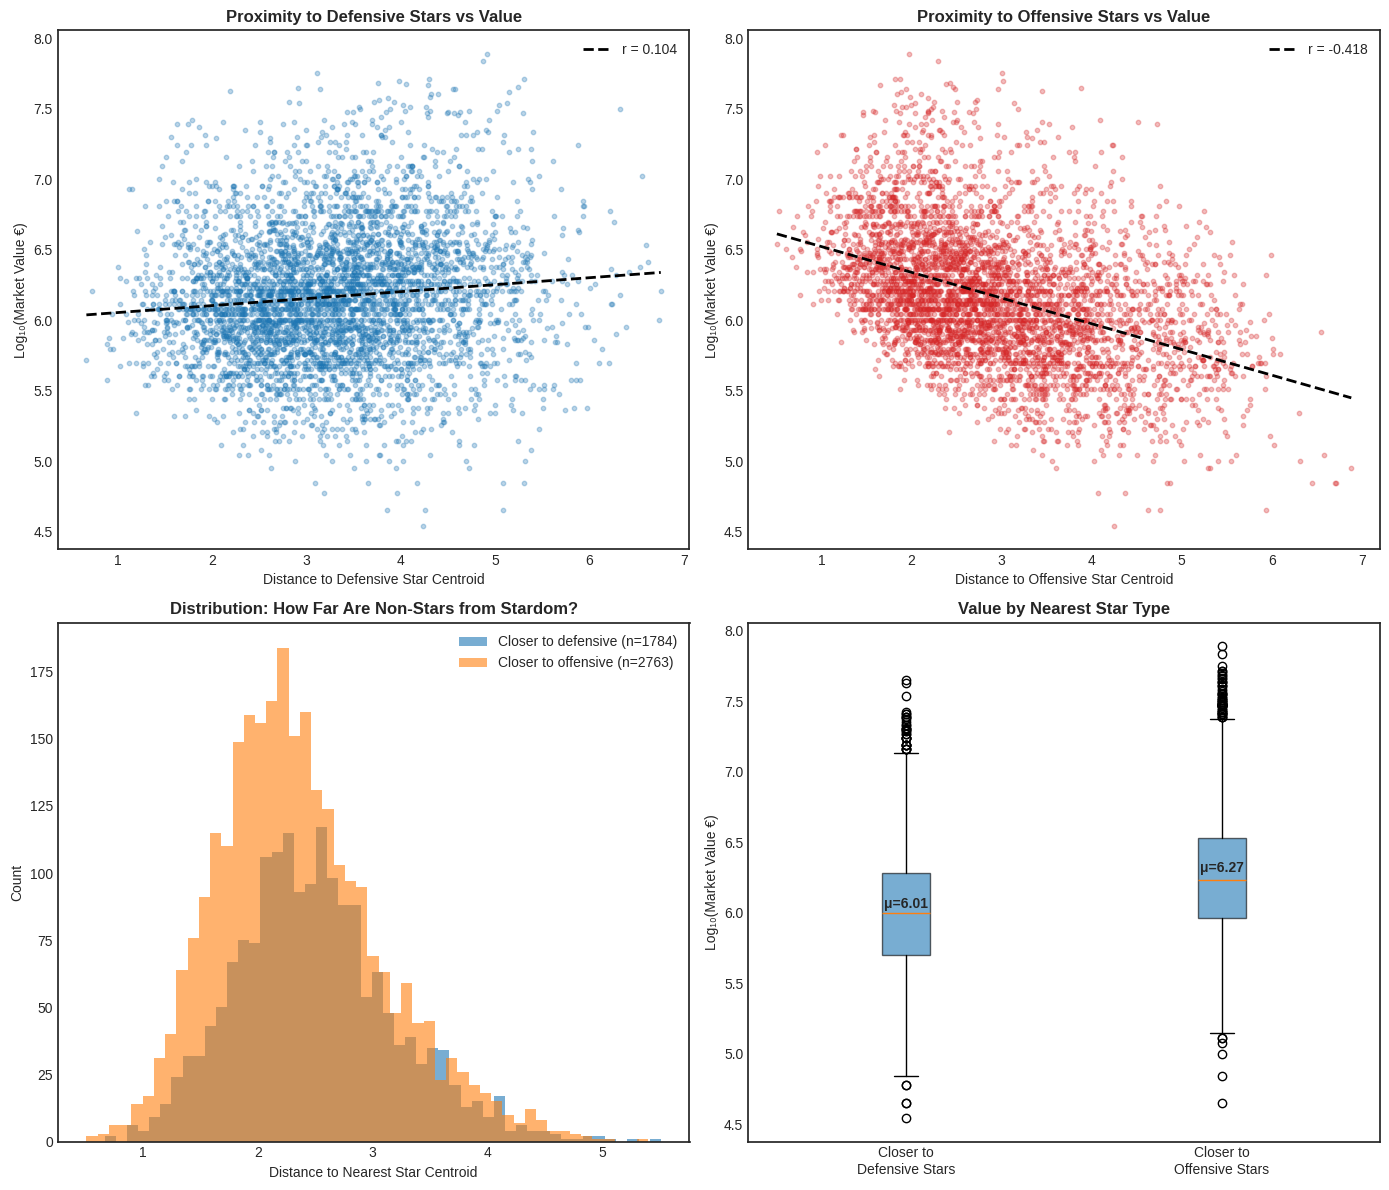

                         mean     median  count
proximity_quartile                             
Closest (Q1)        3733153.0  2000000.0   1137
Q2                  3402155.0  1600000.0   1137
Q3                  2791646.0  1300000.0   1136
Furthest (Q4)       1561381.0   775000.0   1137


/tmp/ipykernel_37983/3725896804.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('proximity_quartile')['value_eur']


In [110]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd


if cluster_means.loc[0, 'defending'] > cluster_means.loc[1, 'defending']:
    defensive_cluster, offensive_cluster = 0, 1
else:
    defensive_cluster, offensive_cluster = 1, 0

print(f"Defensive star cluster: {defensive_cluster}")
print(f"Offensive star cluster: {offensive_cluster}")

# Non-star distances
non_star_df = outfield_df[outfield_df["is_star"] == 0].copy()
X_non_star = non_star_df[features].dropna()
X_non_star_scaled = scaler.transform(X_non_star)

distances = cdist(X_non_star_scaled, kmeans.cluster_centers_, metric='euclidean')

non_star_df.loc[X_non_star.index, 'dist_to_defensive_star'] = distances[:, defensive_cluster]
non_star_df.loc[X_non_star.index, 'dist_to_offensive_star'] = distances[:, offensive_cluster]
non_star_df.loc[X_non_star.index, 'dist_to_nearest_star'] = distances.min(axis=1)
non_star_df.loc[X_non_star.index, 'nearest_star_type'] = np.where(
    distances.argmin(axis=1) == defensive_cluster, 'defensive', 'offensive'
)

analysis_df = non_star_df.dropna(subset=['dist_to_nearest_star', 'value_eur'])
analysis_df = analysis_df[analysis_df['value_eur'] > 0]
analysis_df['log_value'] = np.log10(analysis_df['value_eur'])

# Correlations
corr_def, p_def = stats.pearsonr(
    analysis_df['dist_to_defensive_star'], analysis_df['log_value']
)
corr_off, p_off = stats.pearsonr(
    analysis_df['dist_to_offensive_star'], analysis_df['log_value']
)
corr_near, p_near = stats.pearsonr(
    analysis_df['dist_to_nearest_star'], analysis_df['log_value']
)

print(f"Distance to defensive stars vs log(value): r = {corr_def:.3f}, p = {p_def:.2e}")
print(f"Distance to offensive stars vs log(value): r = {corr_off:.3f}, p = {p_off:.2e}")
print(f"Distance to nearest star vs log(value):    r = {corr_near:.3f}, p = {p_near:.2e}")

# Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Distance to defensive (blue)
ax1 = axes[0, 0]
ax1.scatter(
    analysis_df['dist_to_defensive_star'],
    analysis_df['log_value'],
    alpha=0.3,
    s=10,
    color='tab:blue'
)
z = np.polyfit(
    analysis_df['dist_to_defensive_star'],
    analysis_df['log_value'],
    1
)
p = np.poly1d(z)
x_line = np.linspace(
    analysis_df['dist_to_defensive_star'].min(),
    analysis_df['dist_to_defensive_star'].max(),
    100
)
ax1.plot(x_line, p(x_line), 'k--', linewidth=2, label=f'r = {corr_def:.3f}')
ax1.set_xlabel('Distance to Defensive Star Centroid')
ax1.set_ylabel('Log₁₀(Market Value €)')
ax1.set_title('Proximity to Defensive Stars vs Value', fontweight='bold')
ax1.legend()

# Distance to offensive (red)
ax2 = axes[0, 1]
ax2.scatter(
    analysis_df['dist_to_offensive_star'],
    analysis_df['log_value'],
    alpha=0.3,
    s=10,
    color='tab:red'
)
z = np.polyfit(
    analysis_df['dist_to_offensive_star'],
    analysis_df['log_value'],
    1
)
p = np.poly1d(z)
x_line = np.linspace(
    analysis_df['dist_to_offensive_star'].min(),
    analysis_df['dist_to_offensive_star'].max(),
    100
)
ax2.plot(x_line, p(x_line), 'k--', linewidth=2, label=f'r = {corr_off:.3f}')
ax2.set_xlabel('Distance to Offensive Star Centroid')
ax2.set_ylabel('Log₁₀(Market Value €)')
ax2.set_title('Proximity to Offensive Stars vs Value', fontweight='bold')
ax2.legend()

# Histogram of nearest distances (default cycle → blue/red)
ax3 = axes[1, 0]
for star_type in ['defensive', 'offensive']:
    subset = analysis_df[analysis_df['nearest_star_type'] == star_type]
    ax3.hist(
        subset['dist_to_nearest_star'],
        bins=50,
        alpha=0.6,
        label=f'Closer to {star_type} (n={len(subset)})'
    )
ax3.set_xlabel('Distance to Nearest Star Centroid')
ax3.set_ylabel('Count')
ax3.set_title('Distribution: How Far Are Non-Stars from Stardom?', fontweight='bold')
ax3.legend()

# Boxplot
ax4 = axes[1, 1]
def_vals = analysis_df[analysis_df['nearest_star_type'] == 'defensive']['log_value']
off_vals = analysis_df[analysis_df['nearest_star_type'] == 'offensive']['log_value']

bp = ax4.boxplot(
    [def_vals, off_vals],
    labels=['Closer to\nDefensive Stars', 'Closer to\nOffensive Stars'],
    patch_artist=True
)

for box in bp['boxes']:
    box.set_alpha(0.6)

ax4.set_ylabel('Log₁₀(Market Value €)')
ax4.set_title('Value by Nearest Star Type', fontweight='bold')

ax4.text(1, def_vals.mean(), f'μ={def_vals.mean():.2f}', ha='center', va='bottom', fontweight='bold')
ax4.text(2, off_vals.mean(), f'μ={off_vals.mean():.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary stats
analysis_df['proximity_quartile'] = pd.qcut(
    analysis_df['dist_to_nearest_star'],
    4,
    labels=['Closest (Q1)', 'Q2', 'Q3', 'Furthest (Q4)']
)

print(
    analysis_df
    .groupby('proximity_quartile')['value_eur']
    .agg(['mean', 'median', 'count'])
    .round(0)
)


In [118]:
# ============================================================
# REAL EURO VALUATION PREMIUM
# (Follows directly from histogram / distance analysis)
# ============================================================

import numpy as np
from scipy import stats


# ------------------------------------------------------------
# 1. SAMPLE SPLIT (already defined in previous cell)
# ------------------------------------------------------------

def_vals = analysis_df.loc[
    analysis_df["nearest_star_type"] == "defensive",
    "log_value"
]

off_vals = analysis_df.loc[
    analysis_df["nearest_star_type"] == "offensive",
    "log_value"
]


# ------------------------------------------------------------
# 2. LOG-SPACE MEANS
# ------------------------------------------------------------

def_mean_log = def_vals.mean()
off_mean_log = off_vals.mean()

log_gap = off_mean_log - def_mean_log


# ------------------------------------------------------------
# 3. CONVERT TO EURO VALUES
# ------------------------------------------------------------

def_mean_eur = 10 ** def_mean_log
off_mean_eur = 10 ** off_mean_log

mean_multiplier = off_mean_eur / def_mean_eur
mean_premium_eur = off_mean_eur - def_mean_eur


# ------------------------------------------------------------
# 4. MEDIAN-BASED PREMIUM (LEVELS, NOT LOGS)
# ------------------------------------------------------------

def_median_eur = analysis_df.loc[
    analysis_df["nearest_star_type"] == "defensive",
    "value_eur"
].median()

off_median_eur = analysis_df.loc[
    analysis_df["nearest_star_type"] == "offensive",
    "value_eur"
].median()

median_multiplier = off_median_eur / def_median_eur
median_premium_eur = off_median_eur - def_median_eur


# ------------------------------------------------------------
# 5. STATISTICAL SIGNIFICANCE (OPTIONAL)
# ------------------------------------------------------------

t_stat, p_val = stats.ttest_ind(
    off_vals,
    def_vals,
    equal_var=False
)


# ------------------------------------------------------------
# 6. OUTPUT
# ------------------------------------------------------------

print("=" * 70)
print("REAL MARKET VALUATION PREMIUM")
print("Offensive-Leaning vs Defensive-Leaning Non-Star Players")
print("=" * 70)

print("\nSample sizes:")
print(f"  Defensive-leaning: n = {len(def_vals):,}")
print(f"  Offensive-leaning: n = {len(off_vals):,}")

print("\nMean log₁₀ market value:")
print(f"  Defensive-leaning: {def_mean_log:.3f}")
print(f"  Offensive-leaning: {off_mean_log:.3f}")
print(f"  Log gap:           {log_gap:.3f}")

print("\nMean market value (€):")
print(f"  Defensive-leaning: €{def_mean_eur:,.0f}")
print(f"  Offensive-leaning: €{off_mean_eur:,.0f}")
print(f"  Multiplier:        {mean_multiplier:.2f}×")
print(f"  Euro premium:      €{mean_premium_eur:,.0f}")

print("\nMedian market value (€):")
print(f"  Defensive-leaning: €{def_median_eur:,.0f}")
print(f"  Offensive-leaning: €{off_median_eur:,.0f}")
print(f"  Multiplier:        {median_multiplier:.2f}×")
print(f"  Euro premium:      €{median_premium_eur:,.0f}")

print("\nStatistical test (log values):")
print(f"  Welch t-stat: {t_stat:.2f}")
print(f"  p-value:      {p_val:.2e}")

print("=" * 70)


REAL MARKET VALUATION PREMIUM
Offensive-Leaning vs Defensive-Leaning Non-Star Players

Sample sizes:
  Defensive-leaning: n = 1,784
  Offensive-leaning: n = 2,763

Mean log₁₀ market value:
  Defensive-leaning: 6.012
  Offensive-leaning: 6.268
  Log gap:           0.256

Mean market value (€):
  Defensive-leaning: €1,029,105
  Offensive-leaning: €1,855,561
  Multiplier:        1.80×
  Euro premium:      €826,456

Median market value (€):
  Defensive-leaning: €1,000,000
  Offensive-leaning: €1,700,000
  Multiplier:        1.70×
  Euro premium:      €700,000

Statistical test (log values):
  Welch t-stat: 18.63
  p-value:      3.55e-74


Defensive star cluster: 1
Offensive star cluster: 0

POSITION-SEGMENTED PROXIMITY ANALYSIS

Detected positions: ['att', 'def', 'mid']

Position distribution:
formation
def    1892
mid    1837
att     818
Name: count, dtype: int64

ATT → Defensive Stars (n=818)
  r = +0.150, p = 1.64e-05

DEF → Defensive Stars (n=1892)
  r = -0.088, p = 1.21e-04

MID → Defensive Stars (n=1837)
  r = +0.188, p = 4.56e-16

ATT → Offensive Stars (n=818)
  r = -0.509, p = 4.91e-55

DEF → Offensive Stars (n=1892)
  r = -0.372, p = 2.95e-63

MID → Offensive Stars (n=1837)
  r = -0.474, p = 1.51e-103


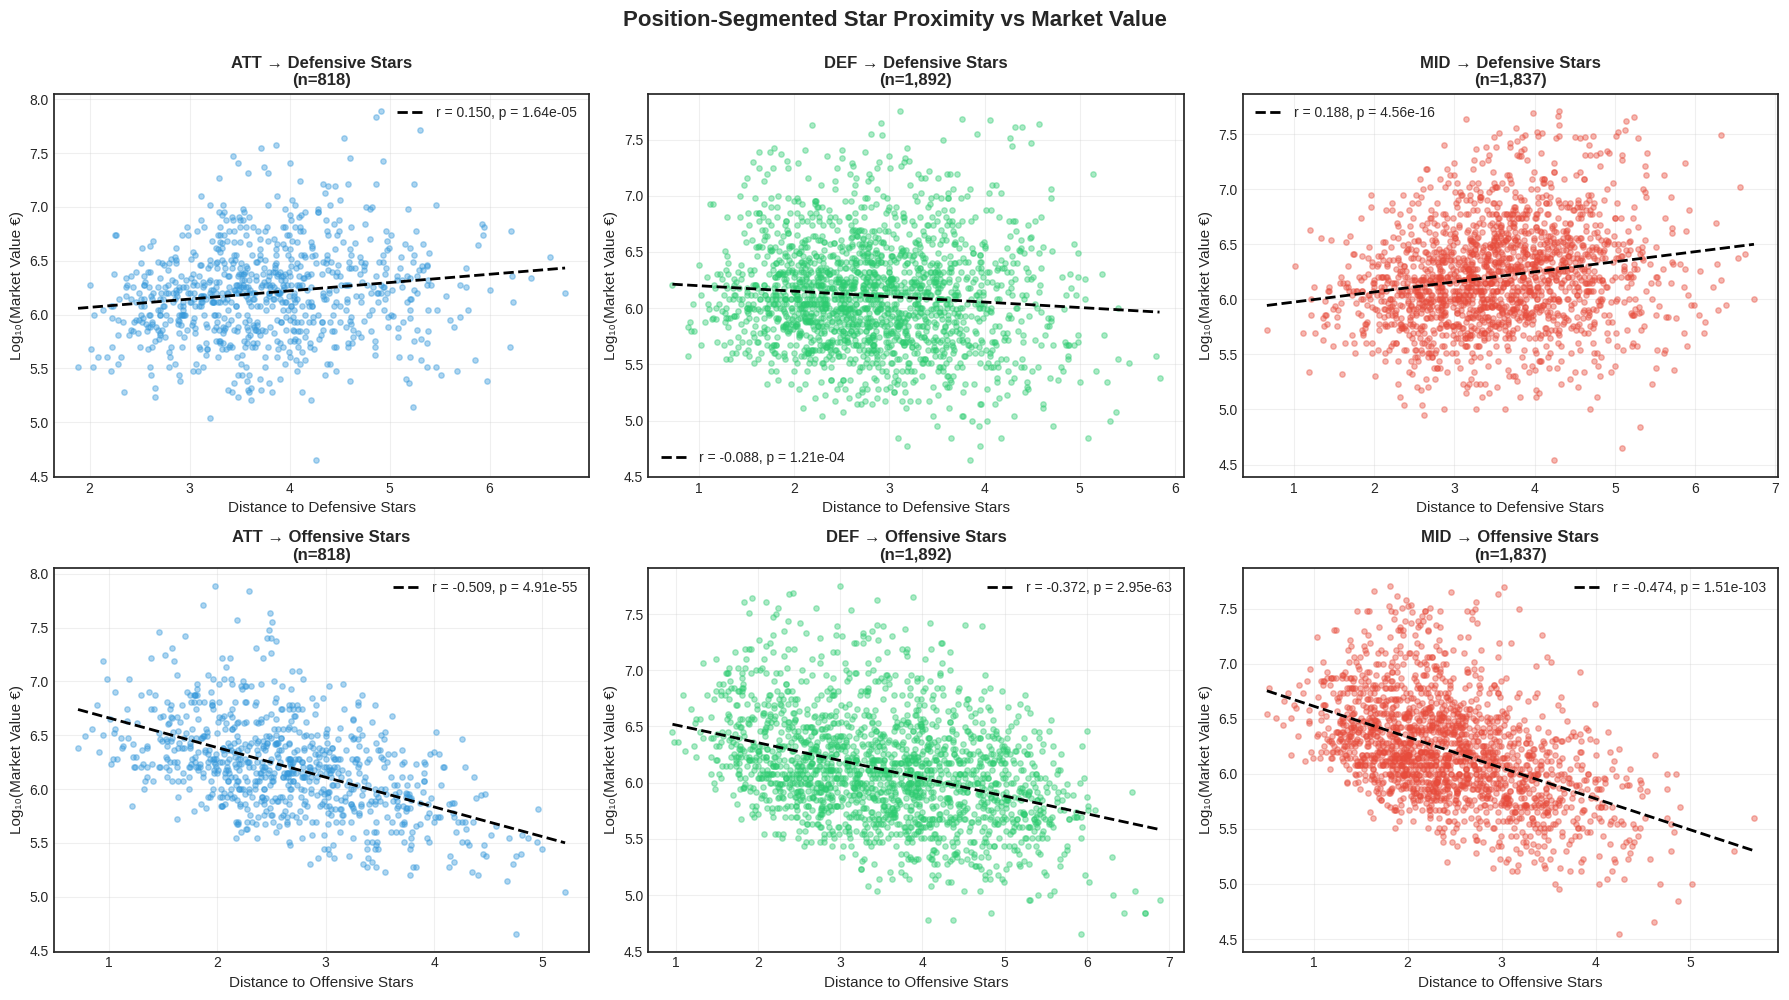

In [111]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Determine which cluster is defensive vs offensive
if cluster_means.loc[0, 'defending'] > cluster_means.loc[1, 'defending']:
    defensive_cluster, offensive_cluster = 0, 1
else:
    defensive_cluster, offensive_cluster = 1, 0

print(f"Defensive star cluster: {defensive_cluster}")
print(f"Offensive star cluster: {offensive_cluster}")

# Calculate distances for non-stars
non_star_df = outfield_df[outfield_df["is_star"] == 0].copy()
X_non_star = non_star_df[features].dropna()
X_non_star_scaled = scaler.transform(X_non_star)

distances = cdist(X_non_star_scaled, kmeans.cluster_centers_, metric='euclidean')

non_star_df.loc[X_non_star.index, 'dist_to_defensive_star'] = distances[:, defensive_cluster]
non_star_df.loc[X_non_star.index, 'dist_to_offensive_star'] = distances[:, offensive_cluster]

analysis_df = non_star_df.dropna(subset=['dist_to_defensive_star', 'dist_to_offensive_star', 'value_eur', 'formation'])
analysis_df = analysis_df[analysis_df['value_eur'] > 0]
analysis_df['log_value'] = np.log10(analysis_df['value_eur'])

# Auto-detect unique position groups
positions = analysis_df['formation'].unique()
positions = [p for p in positions if pd.notna(p)]  # Remove NaN if any
positions = sorted(positions)  # Sort for consistency

print("\n" + "="*80)
print("POSITION-SEGMENTED PROXIMITY ANALYSIS")
print("="*80)
print(f"\nDetected positions: {positions}")
print("\nPosition distribution:")
print(analysis_df['formation'].value_counts())

# Define colors (cycle through if more than 3)
color_palette = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c']
colors = {pos: color_palette[i % len(color_palette)] for i, pos in enumerate(positions)}

# Create visualization: 2 rows (defensive/offensive stars) x N columns (positions)
n_positions = len(positions)
fig, axes = plt.subplots(2, n_positions, figsize=(6*n_positions, 10))

# Handle case where there's only 1 position
if n_positions == 1:
    axes = axes.reshape(-1, 1)

# Row 1: Distance to Defensive Stars by Position
for idx, position in enumerate(positions):
    ax = axes[0, idx]
    pos_df = analysis_df[analysis_df['formation'] == position].copy()
    
    if len(pos_df) < 30:
        ax.text(0.5, 0.5, f'Insufficient data\n(n={len(pos_df)})', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{position.upper()} → Defensive Stars', fontweight='bold')
        continue
    
    ax.scatter(
        pos_df['dist_to_defensive_star'],
        pos_df['log_value'],
        alpha=0.4,
        s=15,
        color=colors[position]
    )
    
    # Regression line
    z = np.polyfit(pos_df['dist_to_defensive_star'], pos_df['log_value'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(pos_df['dist_to_defensive_star'].min(), 
                         pos_df['dist_to_defensive_star'].max(), 100)
    
    corr, p_val = stats.pearsonr(pos_df['dist_to_defensive_star'], pos_df['log_value'])
    
    ax.plot(x_line, p(x_line), 'k--', linewidth=2, 
            label=f'r = {corr:.3f}, p = {p_val:.2e}')
    
    ax.set_xlabel('Distance to Defensive Stars', fontsize=11)
    ax.set_ylabel('Log₁₀(Market Value €)', fontsize=11)
    ax.set_title(f'{position.upper()} → Defensive Stars\n(n={len(pos_df):,})', fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    print(f"\n{position.upper()} → Defensive Stars (n={len(pos_df)})")
    print(f"  r = {corr:+.3f}, p = {p_val:.2e}")

# Row 2: Distance to Offensive Stars by Position
for idx, position in enumerate(positions):
    ax = axes[1, idx]
    pos_df = analysis_df[analysis_df['formation'] == position].copy()
    
    if len(pos_df) < 30:
        ax.text(0.5, 0.5, f'Insufficient data\n(n={len(pos_df)})', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{position.upper()} → Offensive Stars', fontweight='bold')
        continue
    
    ax.scatter(
        pos_df['dist_to_offensive_star'],
        pos_df['log_value'],
        alpha=0.4,
        s=15,
        color=colors[position]
    )
    
    # Regression line
    z = np.polyfit(pos_df['dist_to_offensive_star'], pos_df['log_value'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(pos_df['dist_to_offensive_star'].min(), 
                         pos_df['dist_to_offensive_star'].max(), 100)
    
    corr, p_val = stats.pearsonr(pos_df['dist_to_offensive_star'], pos_df['log_value'])
    
    ax.plot(x_line, p(x_line), 'k--', linewidth=2, 
            label=f'r = {corr:.3f}, p = {p_val:.2e}')
    
    ax.set_xlabel('Distance to Offensive Stars', fontsize=11)
    ax.set_ylabel('Log₁₀(Market Value €)', fontsize=11)
    ax.set_title(f'{position.upper()} → Offensive Stars\n(n={len(pos_df):,})', fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    print(f"\n{position.upper()} → Offensive Stars (n={len(pos_df)})")
    print(f"  r = {corr:+.3f}, p = {p_val:.2e}")

plt.suptitle('Position-Segmented Star Proximity vs Market Value', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

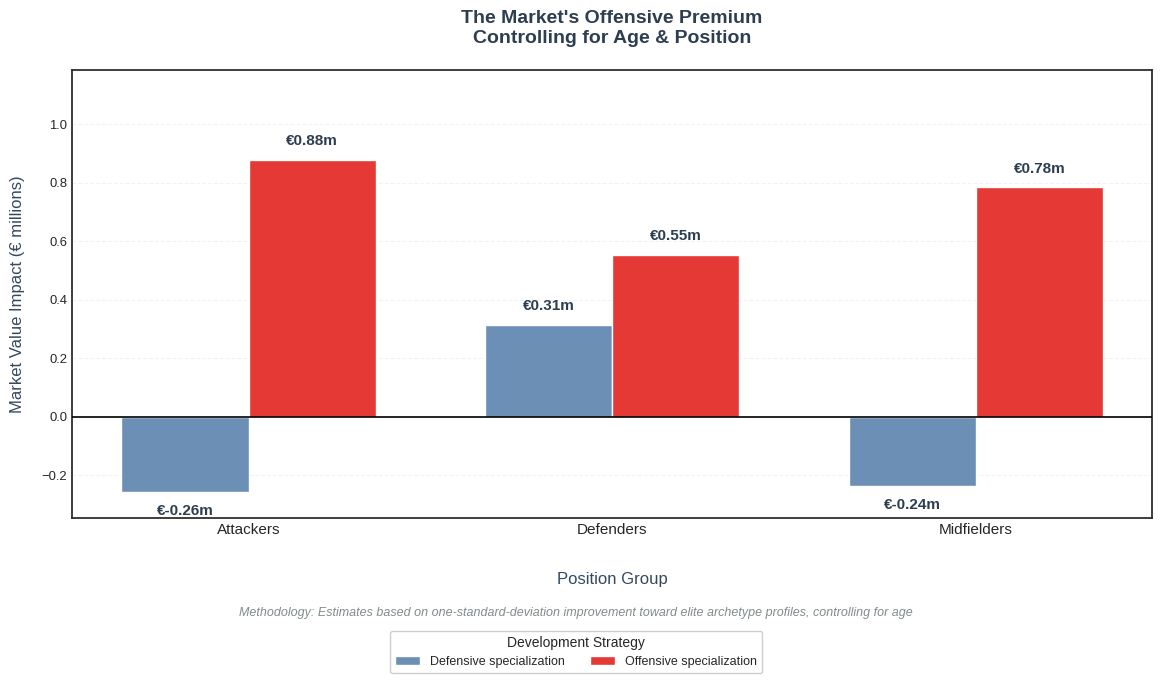


PLAYER DEVELOPMENT ROI SUMMARY (CONTROLLED)
   Position  Defensive (€m)  Offensive (€m)  ROI Ratio
  Attackers       -0.257695        0.877865      -3.41
  Defenders        0.313983        0.553585       1.76
Midfielders       -0.237577        0.784665      -3.30


In [ ]:

# RETURNS TO ELITE PLAYER PROFILES — € TERMS (CONTROLLED)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

LN10 = np.log(10)
rows = []


# POSITION-LEVEL ESTIMATION (CONTROLLED FOR AGE)


for position in positions:

    pos_df = analysis_df[analysis_df["formation"] == position].copy()

    if len(pos_df) < 50:
        continue

    y = pos_df["log_value"]

    median_value = pos_df["value_eur"].median()

    sd_def = pos_df["dist_to_defensive_star"].std()
    sd_off = pos_df["dist_to_offensive_star"].std()

    # Controlled regression: both distances + age
    X = sm.add_constant(pos_df[['dist_to_offensive_star', 'dist_to_defensive_star', 'age']])
    model = sm.OLS(y, X, missing='drop').fit()
    
    beta_off = model.params['dist_to_offensive_star']
    beta_def = model.params['dist_to_defensive_star']

    euro_def = -beta_def * sd_def * LN10 * median_value
    euro_off = -beta_off * sd_off * LN10 * median_value

    rows.append({
        "Position": position,
        "Defensive Profile (€m)": euro_def / 1e6,
        "Offensive Profile (€m)": euro_off / 1e6
    })

coef_df = pd.DataFrame(rows)


# VISUALIZATION


position_labels = {
    "att": "Attackers",
    "mid": "Midfielders",
    "def": "Defenders"
}

coef_df["Position_Label"] = coef_df["Position"].map(position_labels)

fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(coef_df))
width = 0.35

defensive_color = "#6B8FB5"
offensive_color = "#E53935"

bars_def = ax.bar(
    x - width / 2,
    coef_df["Defensive Profile (€m)"],
    width,
    color=defensive_color,
    label="Defensive specialization"
)

bars_off = ax.bar(
    x + width / 2,
    coef_df["Offensive Profile (€m)"],
    width,
    color=offensive_color,
    label="Offensive specialization"
)

# ------------------------------------------------------------
# BAR LABELS
# ------------------------------------------------------------

for bars in (bars_def, bars_off):
    for bar in bars:
        height = bar.get_height()
        va = "bottom" if height >= 0 else "top"
        offset = 0.04 if height >= 0 else -0.04

        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + offset,
            f"€{height:.2f}m",
            ha="center",
            va=va,
            fontsize=11,
            fontweight="bold",
            color="#2C3E50"
        )

ax.axhline(0, color="black", linewidth=1.2, zorder=3)


# AXIS HEADROOM

y_max = coef_df[["Defensive Profile (€m)", "Offensive Profile (€m)"]].max().max()
y_min = coef_df[["Defensive Profile (€m)", "Offensive Profile (€m)"]].min().min()

upper_pad = 0.35 * abs(y_max)
lower_pad = 0.35 * abs(y_min)

ax.set_ylim(y_min - lower_pad, y_max + upper_pad)



ax.set_title(
    "The Market's Offensive Premium\nControlling for Age & Position",
    fontsize=14,
    fontweight="bold",
    pad=20,
    color="#2C3E50"
)

ax.set_xlabel(
    "Position Group",
    fontsize=12,
    color="#34495E",
    labelpad=25
)

ax.set_ylabel(
    "Market Value Impact (€ millions)",
    fontsize=12,
    color="#34495E",
    labelpad=12
)

ax.set_xticks(x)
ax.set_xticklabels(coef_df["Position_Label"], fontsize=11)

ax.grid(axis="y", linestyle="--", alpha=0.25, linewidth=0.8)
ax.set_axisbelow(True)



fig.legend(
    handles=[bars_def, bars_off],
    labels=["Defensive specialization", "Offensive specialization"],
    title="Development Strategy",
    title_fontsize=10,
    fontsize=9,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.01),
    ncol=2,
    frameon=True,
    fancybox=True,
    framealpha=0.95
)



fig.text(
    0.5,
    0.10,
    "Methodology: Estimates based on one-standard-deviation improvement toward elite archetype profiles, controlling for age",
    ha="center",
    fontsize=9,
    style="italic",
    color="#7F8C8D"
)

plt.subplots_adjust(top=0.88, bottom=0.24, left=0.08, right=0.98)
plt.show()


# SUMMARY TABLE


print("\n" + "=" * 60)
print("PLAYER DEVELOPMENT ROI SUMMARY (CONTROLLED)")
print("=" * 60)

summary_table = coef_df[
    ["Position_Label", "Defensive Profile (€m)", "Offensive Profile (€m)"]
].copy()

summary_table["ROI Ratio (Off/Def)"] = (
    summary_table["Offensive Profile (€m)"]
    / summary_table["Defensive Profile (€m)"]
).round(2)

summary_table.columns = ["Position", "Defensive (€m)", "Offensive (€m)", "ROI Ratio"]

print(summary_table.to_string(index=False))
print("=" * 60)

In [175]:
# ============================================================
# WHAT DOES A 1 SD IMPROVEMENT LOOK LIKE IN RAW TERMS?
# ============================================================

import pandas as pd
import numpy as np

print("="*70)
print("WHAT DOES A 1 SD IMPROVEMENT ACTUALLY LOOK LIKE?")
print("="*70)

# Features that make up each archetype
offensive_attrs = ['pace', 'shooting', 'passing', 'dribbling']
defensive_attrs = ['defending', 'physic']

for position in positions:
    
    pos_df = analysis_df[analysis_df["formation"] == position].copy()
    
    if len(pos_df) < 50:
        continue
    
    print(f"\n{position.upper()} (n={len(pos_df)})")
    print("-"*50)
    
    # Current averages
    print(f"\nAverage player profile:")
    for attr in offensive_attrs + defensive_attrs:
        print(f"  {attr:<12}: {pos_df[attr].mean():.1f}")
    
    # Distance stats
    off_dist_mean = pos_df['dist_to_offensive_star'].mean()
    off_dist_sd = pos_df['dist_to_offensive_star'].std()
    def_dist_mean = pos_df['dist_to_defensive_star'].mean()
    def_dist_sd = pos_df['dist_to_defensive_star'].std()
    
    print(f"\nDistance to offensive star: {off_dist_mean:.2f} ± {off_dist_sd:.2f}")
    print(f"Distance to defensive star: {def_dist_mean:.2f} ± {def_dist_sd:.2f}")
    
    # What a 1 SD improvement means in distance terms
    print(f"\n1 SD offensive improvement: {off_dist_mean:.2f} → {off_dist_mean - off_dist_sd:.2f} distance")
    print(f"1 SD defensive improvement: {def_dist_mean:.2f} → {def_dist_mean - def_dist_sd:.2f} distance")
    
    # Compare average player to players who ARE 1 SD closer
    close_off = pos_df[pos_df['dist_to_offensive_star'] < (off_dist_mean - off_dist_sd)]
    close_def = pos_df[pos_df['dist_to_defensive_star'] < (def_dist_mean - def_dist_sd)]
    
    if len(close_off) > 10:
        print(f"\nPlayers 1 SD closer to OFFENSIVE star (n={len(close_off)}) vs average:")
        for attr in offensive_attrs:
            diff = close_off[attr].mean() - pos_df[attr].mean()
            print(f"  {attr:<12}: {pos_df[attr].mean():.1f} → {close_off[attr].mean():.1f} ({diff:+.1f})")
    
    if len(close_def) > 10:
        print(f"\nPlayers 1 SD closer to DEFENSIVE star (n={len(close_def)}) vs average:")
        for attr in defensive_attrs:
            diff = close_def[attr].mean() - pos_df[attr].mean()
            print(f"  {attr:<12}: {pos_df[attr].mean():.1f} → {close_def[attr].mean():.1f} ({diff:+.1f})")



WHAT DOES A 1 SD IMPROVEMENT ACTUALLY LOOK LIKE?

ATT (n=818)
--------------------------------------------------

Average player profile:
  pace        : 72.4
  shooting    : 66.6
  passing     : 59.1
  dribbling   : 68.0
  defending   : 34.4
  physic      : 65.2

Distance to offensive star: 2.66 ± 0.82
Distance to defensive star: 3.79 ± 0.87

1 SD offensive improvement: 2.66 → 1.84 distance
1 SD defensive improvement: 3.79 → 2.92 distance

Players 1 SD closer to OFFENSIVE star (n=131) vs average:
  pace        : 72.4 → 77.9 (+5.5)
  shooting    : 66.6 → 69.7 (+3.1)
  passing     : 59.1 → 66.8 (+7.7)
  dribbling   : 68.0 → 73.2 (+5.2)

Players 1 SD closer to DEFENSIVE star (n=138) vs average:
  defending   : 34.4 → 37.2 (+2.8)
  physic      : 65.2 → 73.6 (+8.4)

DEF (n=1892)
--------------------------------------------------

Average player profile:
  pace        : 66.4
  shooting    : 42.4
  passing     : 55.5
  dribbling   : 58.9
  defending   : 65.7
  physic      : 70.2

Distance to

In [178]:
# ============================================================
# WHAT DOES A 0.5 SD IMPROVEMENT LOOK LIKE IN RAW TERMS?
# ============================================================

import pandas as pd
import numpy as np

print("="*70)
print("WHAT DOES A 0.5 SD IMPROVEMENT ACTUALLY LOOK LIKE?")
print("="*70)

# Features that make up each archetype
offensive_attrs = ['pace', 'shooting', 'passing', 'dribbling']
defensive_attrs = ['defending', 'physic']

for position in positions:
    
    pos_df = analysis_df[analysis_df["formation"] == position].copy()
    
    if len(pos_df) < 50:
        continue
    
    print(f"\n{position.upper()} (n={len(pos_df)})")
    print("-"*50)
    
    # Current averages
    print(f"\nAverage player profile:")
    for attr in offensive_attrs + defensive_attrs:
        print(f"  {attr:<12}: {pos_df[attr].mean():.1f}")
    
    # Distance stats
    off_dist_mean = pos_df['dist_to_offensive_star'].mean()
    off_dist_sd = pos_df['dist_to_offensive_star'].std()
    def_dist_mean = pos_df['dist_to_defensive_star'].mean()
    def_dist_sd = pos_df['dist_to_defensive_star'].std()
    
    print(f"\nDistance to offensive star: {off_dist_mean:.2f} ± {off_dist_sd:.2f}")
    print(f"Distance to defensive star: {def_dist_mean:.2f} ± {def_dist_sd:.2f}")
    
    # What a 0.5 SD improvement means in distance terms
    print(f"\n0.5 SD offensive improvement: {off_dist_mean:.2f} → {off_dist_mean - (off_dist_sd * 0.5):.2f} distance")
    print(f"0.5 SD defensive improvement: {def_dist_mean:.2f} → {def_dist_mean - (def_dist_sd * 0.5):.2f} distance")
    
    # Compare average player to players who ARE 0.5 SD closer
    close_off = pos_df[
        (pos_df['dist_to_offensive_star'] < (off_dist_mean - off_dist_sd * 0.25)) & 
        (pos_df['dist_to_offensive_star'] > (off_dist_mean - off_dist_sd * 0.75))
    ]
    close_def = pos_df[
        (pos_df['dist_to_defensive_star'] < (def_dist_mean - def_dist_sd * 0.25)) & 
        (pos_df['dist_to_defensive_star'] > (def_dist_mean - def_dist_sd * 0.75))
    ]
    
    if len(close_off) > 10:
        print(f"\nPlayers ~0.5 SD closer to OFFENSIVE star (n={len(close_off)}) vs average:")
        for attr in offensive_attrs:
            diff = close_off[attr].mean() - pos_df[attr].mean()
            print(f"  {attr:<12}: {pos_df[attr].mean():.1f} → {close_off[attr].mean():.1f} ({diff:+.1f})")
    
    if len(close_def) > 10:
        print(f"\nPlayers ~0.5 SD closer to DEFENSIVE star (n={len(close_def)}) vs average:")
        for attr in defensive_attrs:
            diff = close_def[attr].mean() - pos_df[attr].mean()
            print(f"  {attr:<12}: {pos_df[attr].mean():.1f} → {close_def[attr].mean():.1f} ({diff:+.1f})")



WHAT DOES A 0.5 SD IMPROVEMENT ACTUALLY LOOK LIKE?

ATT (n=818)
--------------------------------------------------

Average player profile:
  pace        : 72.4
  shooting    : 66.6
  passing     : 59.1
  dribbling   : 68.0
  defending   : 34.4
  physic      : 65.2

Distance to offensive star: 2.66 ± 0.82
Distance to defensive star: 3.79 ± 0.87

0.5 SD offensive improvement: 2.66 → 2.25 distance
0.5 SD defensive improvement: 3.79 → 3.35 distance

Players ~0.5 SD closer to OFFENSIVE star (n=164) vs average:
  pace        : 72.4 → 74.9 (+2.5)
  shooting    : 66.6 → 67.8 (+1.1)
  passing     : 59.1 → 62.3 (+3.2)
  dribbling   : 68.0 → 69.9 (+1.9)

Players ~0.5 SD closer to DEFENSIVE star (n=161) vs average:
  defending   : 34.4 → 34.9 (+0.6)
  physic      : 65.2 → 69.4 (+4.2)

DEF (n=1892)
--------------------------------------------------

Average player profile:
  pace        : 66.4
  shooting    : 42.4
  passing     : 55.5
  dribbling   : 58.9
  defending   : 65.7
  physic      : 70.2


In [176]:
# More realistic: 0.5 SD improvement
print("="*70)
print("REALISTIC SCENARIO: 0.5 SD IMPROVEMENT")
print("="*70)

for position in positions:
    
    pos_df = analysis_df[analysis_df["formation"] == position].copy()
    
    if len(pos_df) < 50:
        continue
    
    median_value = pos_df["value_eur"].median()
    sd_off = pos_df["dist_to_offensive_star"].std()
    
    # Get beta from controlled regression
    X = sm.add_constant(pos_df[['dist_to_offensive_star', 'dist_to_defensive_star', 'age']])
    y = pos_df['log_value']
    model = sm.OLS(y, X, missing='drop').fit()
    beta_off = model.params['dist_to_offensive_star']
    
    # 0.5 SD improvement
    euro_half_sd = -beta_off * (sd_off * 0.5) * LN10 * median_value / 1e6
    
    print(f"\n{position.upper()}:")
    print(f"  0.5 SD offensive improvement: €{euro_half_sd:.2f}m value gain")
    print(f"  Requires roughly: +3 to +5 points across offensive attributes")

REALISTIC SCENARIO: 0.5 SD IMPROVEMENT

ATT:
  0.5 SD offensive improvement: €0.44m value gain
  Requires roughly: +3 to +5 points across offensive attributes

DEF:
  0.5 SD offensive improvement: €0.28m value gain
  Requires roughly: +3 to +5 points across offensive attributes

MID:
  0.5 SD offensive improvement: €0.39m value gain
  Requires roughly: +3 to +5 points across offensive attributes


### **If the market places a premium on being close to an Offesnive STARS, what makes a close offensive star?**

CORRELATIONS: Raw features vs Distance to Offensive Star Centroid

(Negative = closer to offensive stars, Positive = further away)

dribbling   -0.828
passing     -0.774
shooting    -0.737
pace        -0.548
age         -0.046
physic       0.034
defending    0.177
weight_kg    0.330
height_cm    0.400


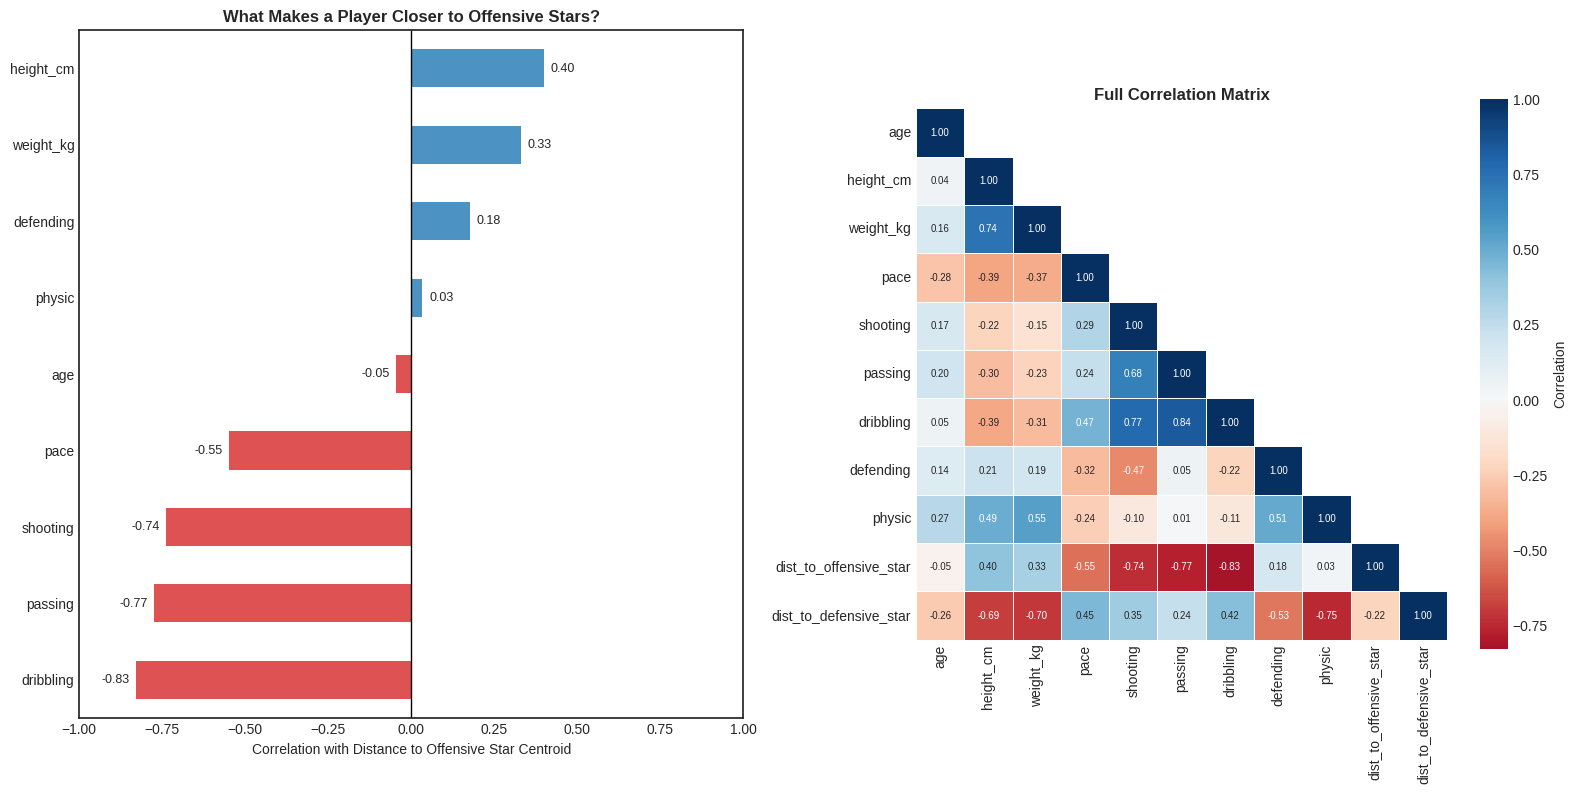


INTERPRETATION

Features that make players CLOSER to offensive stars (negative correlation):
  • dribbling: r = -0.828
  • passing: r = -0.774
  • shooting: r = -0.737
  • pace: r = -0.548
  • age: r = -0.046

Features that make players FURTHER from offensive stars (positive correlation):
  • height_cm: r = 0.400
  • weight_kg: r = 0.330
  • defending: r = 0.177
  • physic: r = 0.034
  • age: r = -0.046


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

base_features = [
    "age",
    "height_cm",
    "weight_kg",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
]


# Correlations with distance to offensive star
corr_cols = base_features + [
 
    'dist_to_offensive_star',
    'dist_to_defensive_star'
]
corr_cols = [c for c in corr_cols if c in analysis_df.columns]

corr_matrix = analysis_df[corr_cols].corr()

off_corrs = (
    corr_matrix['dist_to_offensive_star']
    .drop(['dist_to_offensive_star', 'dist_to_defensive_star'])
    .sort_values()
)

print("=" * 60)
print("CORRELATIONS: Raw features vs Distance to Offensive Star Centroid")
print("=" * 60)
print("\n(Negative = closer to offensive stars, Positive = further away)\n")
print(off_corrs.round(3).to_string())

# Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar chart (red = negative, blue = positive)
ax1 = axes[0]
colors_bar = ['tab:red' if x < 0 else 'tab:blue' for x in off_corrs.values]
off_corrs.plot(
    kind='barh',
    ax=ax1,
    color=colors_bar,
    alpha=0.8
)
ax1.axvline(x=0, color='black', linewidth=1)
ax1.set_xlabel('Correlation with Distance to Offensive Star Centroid')
ax1.set_title('What Makes a Player Closer to Offensive Stars?', fontweight='bold')
ax1.set_xlim(-1, 1)

for i, val in enumerate(off_corrs.values):
    ax1.text(
        val + 0.02 if val >= 0 else val - 0.02,
        i,
        f'{val:.2f}',
        va='center',
        ha='left' if val >= 0 else 'right',
        fontsize=9
    )

# Correlation heatmap (red–blue)
ax2 = axes[1]
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='RdBu',
    center=0,
    annot=True,
    fmt='.2f',
    annot_kws={'size': 7},
    square=True,
    linewidths=0.5,
    ax=ax2,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'}
)
ax2.set_title('Full Correlation Matrix', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)

print("\nFeatures that make players CLOSER to offensive stars (negative correlation):")
for feat, corr in off_corrs.head(5).items():
    print(f"  • {feat}: r = {corr:.3f}")

print("\nFeatures that make players FURTHER from offensive stars (positive correlation):")
for feat, corr in off_corrs.tail(5).iloc[::-1].items():
    print(f"  • {feat}: r = {corr:.3f}")


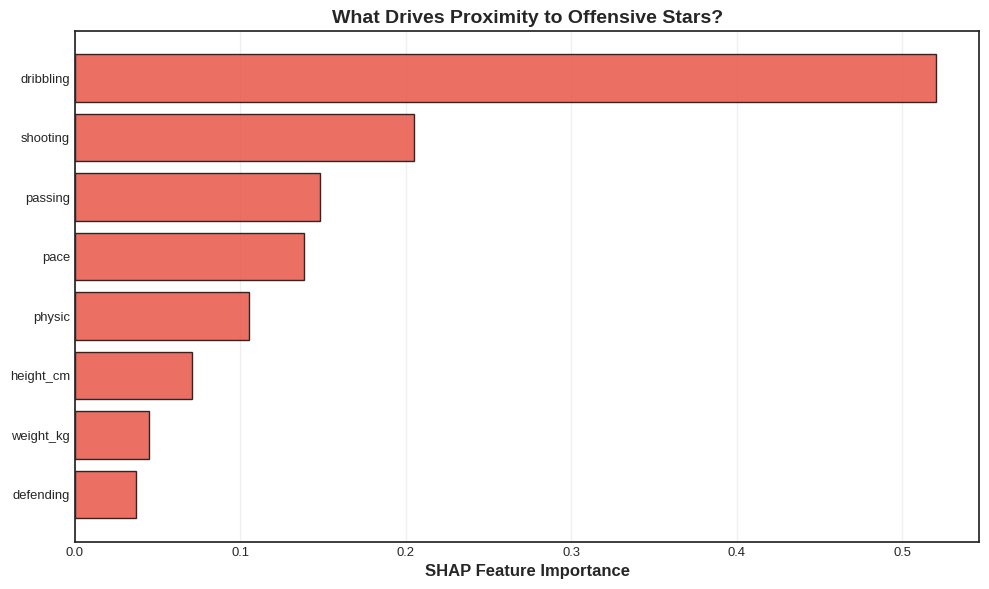

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import shap

base_features = [
  
    "pace",
    "shooting",
    "passing",
    "dribbling",
    
]

# Prepare data
feature_cols = [f for f in base_features if f in analysis_df.columns]
analysis_clean = analysis_df[feature_cols + ['dist_to_offensive_star']].dropna()

X = analysis_clean[feature_cols]
y = analysis_clean['dist_to_offensive_star']

# Standardize
scaler_ml = StandardScaler()
X_scaled = scaler_ml.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_scaled_df, y)

# SHAP - SAMPLE ONLY 500 PLAYERS FOR SPEED
X_sample = X_scaled_df.sample(n=500, random_state=42)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)  # Only compute for sample

shap_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

shap_importance_sorted = shap_importance.sort_values('importance')
ax.barh(shap_importance_sorted['feature'], shap_importance_sorted['importance'], 
        color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_xlabel('SHAP Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('What Drives Proximity to Offensive Stars?', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### By position?



Computing SHAP for DEF
Players in group: 1892
Top 3 drivers for DEF:
   dribbling: 0.571
   shooting: 0.291
   pace: 0.220

Computing SHAP for MID
Players in group: 1837
Top 3 drivers for MID:
   dribbling: 0.234
   pace: 0.210
   passing: 0.172

Computing SHAP for ATT
Players in group: 818
Top 3 drivers for ATT:
   passing: 0.377
   pace: 0.171
   shooting: 0.115


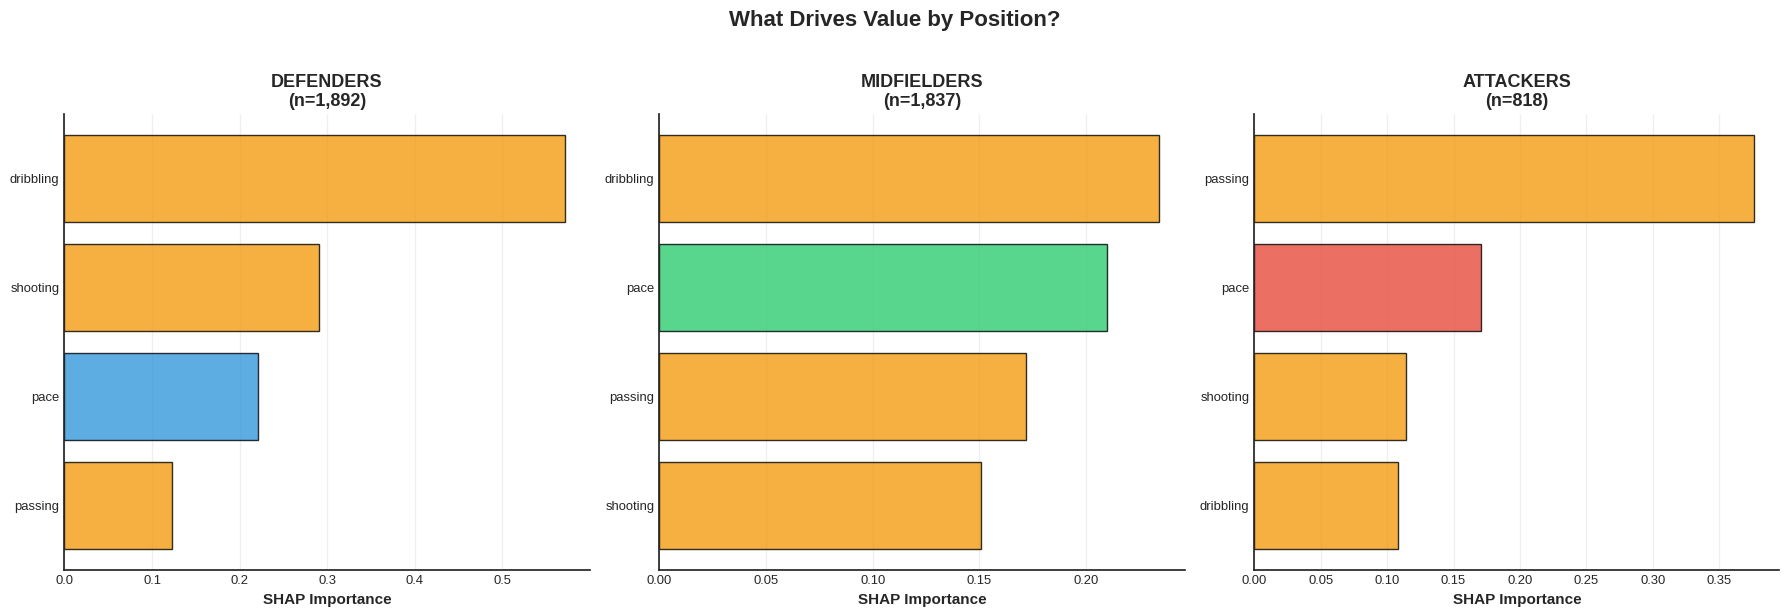


RECOMMENDED SKILL WEIGHTS BY FORMATION

DEF:
   dribbling: 2.0
   shooting: 1.02
   passing: 0.43

MID:
   dribbling: 2.0
   passing: 1.47
   shooting: 1.29

ATT:
   passing: 2.0
   shooting: 0.61
   dribbling: 0.58


In [216]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import shap

# ============================================================
# CONFIGURATION
# ============================================================

base_features = [
    
    "pace",
    "shooting",
    "passing",
    "dribbling",
    
]

# ============================================================
# RUN SHAP BY FORMATION
# ============================================================

def compute_shap_by_formation(df, formation_col='formation', target_col='dist_to_offensive_star', sample_size=500):
    """
    Run SHAP analysis separately for def, mid, att.
    """
    
    feature_cols = [f for f in base_features if f in df.columns]
    results = {}
    
    for group in ['def', 'mid', 'att']:
        print(f"\n{'='*50}")
        print(f"Computing SHAP for {group.upper()}")
        print('='*50)
        
        group_df = df[df[formation_col] == group].copy()
        print(f"Players in group: {len(group_df)}")
        
        if len(group_df) < 100:
            print(f"Skipping {group} - insufficient players")
            continue
        
        analysis_clean = group_df[feature_cols + [target_col]].dropna()
        X = analysis_clean[feature_cols]
        y = analysis_clean[target_col]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)
        
        rf = RandomForestRegressor(
            n_estimators=200, 
            max_depth=10, 
            random_state=42, 
            n_jobs=-1
        )
        rf.fit(X_scaled_df, y)
        
        n_sample = min(sample_size, len(X_scaled_df))
        X_sample = X_scaled_df.sample(n=n_sample, random_state=42)
        
        explainer = shap.TreeExplainer(rf)
        shap_values = explainer.shap_values(X_sample)
        
        shap_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': np.abs(shap_values).mean(axis=0)
        }).sort_values('importance', ascending=False)
        
        results[group] = {
            'importance': shap_importance,
            'n_players': len(group_df)
        }
        
        print(f"Top 3 drivers for {group.upper()}:")
        for _, row in shap_importance.head(3).iterrows():
            print(f"   {row['feature']}: {row['importance']:.3f}")
    
    return results


def plot_shap_by_formation(results):
    """
    Side-by-side SHAP importance plots for def/mid/att
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    colors = {'def': '#3498db', 'mid': '#2ecc71', 'att': '#e74c3c'}
    titles = {'def': 'DEFENDERS', 'mid': 'MIDFIELDERS', 'att': 'ATTACKERS'}
    offensive_skills = ['dribbling', 'passing', 'shooting']
    
    for idx, group in enumerate(['def', 'mid', 'att']):
        ax = axes[idx]
        
        if group not in results:
            ax.text(0.5, 0.5, f'No data for {group}', ha='center', va='center')
            continue
        
        importance = results[group]['importance'].sort_values('importance')
        n_players = results[group]['n_players']
        
        bar_colors = [
            '#f39c12' if f in offensive_skills else colors[group] 
            for f in importance['feature']
        ]
        
        ax.barh(importance['feature'], importance['importance'],
                color=bar_colors, alpha=0.8, edgecolor='black')
        
        ax.set_xlabel('SHAP Importance', fontsize=11, fontweight='bold')
        ax.set_title(f"{titles[group]}\n(n={n_players:,})", fontsize=13, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        ax.spines[['top', 'right']].set_visible(False)
    
    plt.suptitle('What Drives Value by Position?', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def get_formation_skill_weights(results):
    """
    Extract skill weights by formation from SHAP results.
    """
    
    offensive_skills = ['dribbling', 'passing', 'shooting']
    formation_weights = {}
    
    for group, data in results.items():
        importance = data['importance']
        offensive = importance[importance['feature'].isin(offensive_skills)].copy()
        
        max_imp = offensive['importance'].max()
        offensive['weight'] = offensive['importance'] / max_imp * 2.0
        
        formation_weights[group] = {
            row['feature']: round(row['weight'], 2)
            for _, row in offensive.iterrows()
        }
    
    return formation_weights


# ============================================================
# USAGE
# ============================================================

results = compute_shap_by_formation(analysis_df)
plot_shap_by_formation(results)

formation_weights = get_formation_skill_weights(results)

print("\n" + "="*60)
print("RECOMMENDED SKILL WEIGHTS BY FORMATION")
print("="*60)
for group, weights in formation_weights.items():
    print(f"\n{group.upper()}:")
    for skill, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
        print(f"   {skill}: {weight}")

Now we know that there is a clear subset of skills and traits associated with closenss to stardom, we know the market places a premium on these skills.

We want to investigate does this premium vary based on other characteristics? 

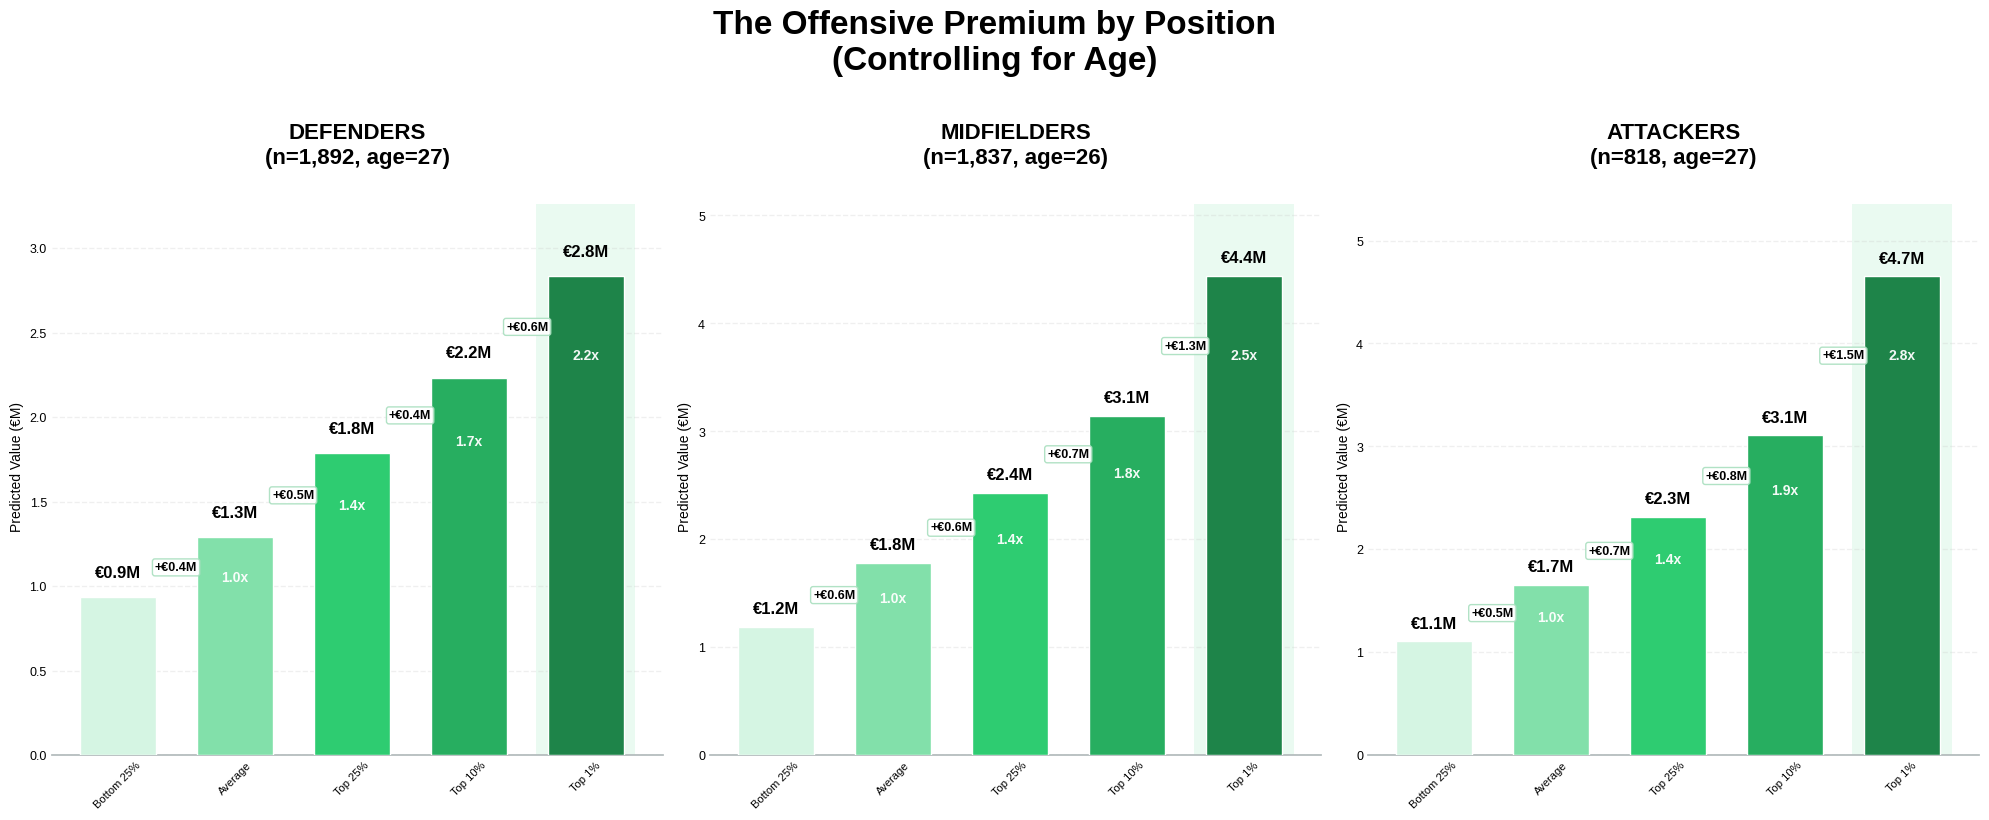


OFFENSIVE PREMIUM BY POSITION - EXECUTIVE SUMMARY
(Controlling for Age)

DEF (n=1,892, predicted at age 27)
--------------------------------------------------
  Bottom 25%:  €0.9M
  Average:     €1.3M
  Top 10%:     €2.2M
  Top 1%:      €2.8M
  Elite premium (Top 1% vs Average): 2.2x (+€1.5M)
  Value unlocked (Bottom 25% → Average): +€0.35M

MID (n=1,837, predicted at age 26)
--------------------------------------------------
  Bottom 25%:  €1.2M
  Average:     €1.8M
  Top 10%:     €3.1M
  Top 1%:      €4.4M
  Elite premium (Top 1% vs Average): 2.5x (+€2.7M)
  Value unlocked (Bottom 25% → Average): +€0.60M

ATT (n=818, predicted at age 27)
--------------------------------------------------
  Bottom 25%:  €1.1M
  Average:     €1.7M
  Top 10%:     €3.1M
  Top 1%:      €4.7M
  Elite premium (Top 1% vs Average): 2.8x (+€3.0M)
  Value unlocked (Bottom 25% → Average): +€0.55M

CROSS-POSITION COMPARISON

Elite (Top 1%) values:
  DEF: €2.8M
  MID: €4.4M
  ATT: €4.7M

Biggest jump (Bottom 25% 

In [180]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import statsmodels.api as sm

# ==========================================
# 1. COMPUTE OFFENSIVE PREMIUM BY FORMATION
# ==========================================

def compute_offensive_premium(df, formation=None):
    """
    Compute predicted values at each percentile for a given formation.
    Controls for age — predicts at median age.
    """
    
    if formation:
        data = df[df['formation'] == formation].copy()
        label = formation.upper()
    else:
        data = df.copy()
        label = "ALL"
    
    data['dist_scaled'] = (
        data['dist_to_offensive_star'] - data['dist_to_offensive_star'].mean()
    ) / data['dist_to_offensive_star'].std()
    
    data['log_value'] = np.log10(data['value_eur'])
    
    # Controlled regression: distance + age
    X = sm.add_constant(data[['dist_scaled', 'age']])
    y = data['log_value']
    model = sm.OLS(y, X, missing='drop').fit()
    
    # Predict at median age
    median_age = data['age'].median()
    
    percentiles = [75, 50, 25, 10, 1]
    results = []
    
    for p in percentiles:
        dist = data['dist_to_offensive_star'].quantile(p / 100)
        dist_scaled = (
            dist - data['dist_to_offensive_star'].mean()
        ) / data['dist_to_offensive_star'].std()
        
        # Predict at this distance AND median age
        predicted_log = (
            model.params['const'] + 
            model.params['dist_scaled'] * dist_scaled + 
            model.params['age'] * median_age
        )
        predicted_value = 10 ** predicted_log
        results.append({
            'percentile': p,
            'predicted_value': predicted_value
        })
    
    return {
        'formation': label,
        'n_players': len(data),
        'median_age': median_age,
        'results': results,
        'values': [r['predicted_value'] / 1_000_000 for r in results]
    }


# ==========================================
# 2. PLOT OFFENSIVE PREMIUM BY FORMATION
# ==========================================

def plot_offensive_premium_by_formation(df):
    """
    Side-by-side offensive premium charts for def/mid/att
    """
    
    formations = ['def', 'mid', 'att']
    titles = {'def': 'DEFENDERS', 'mid': 'MIDFIELDERS', 'att': 'ATTACKERS'}
    labels = ['Bottom 25%', 'Average', 'Top 25%', 'Top 10%', 'Top 1%']

    colors_professional = [
        '#D5F5E3',
        '#82E0AA',
        '#2ECC71',
        '#27AE60',
        '#1E8449'
    ]
    
    formation_data = {f: compute_offensive_premium(df, f) for f in formations}
    
    plt.style.use('seaborn-v0_8-white')
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    
    for idx, formation in enumerate(formations):
        ax = axes[idx]
        data = formation_data[formation]
        values = data['values']
        n_players = data['n_players']
        median_age = data['median_age']
        
        bars = ax.bar(labels, values, color=colors_professional, width=0.65, zorder=3)
        
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.1,
                f'€{val:.1f}M',
                ha='center',
                va='bottom',
                fontsize=12,
                fontweight='bold',
                color='black'
            )
        
        baseline = values[1]
        for i, (bar, val) in enumerate(zip(bars, values)):
            if i == 0:
                continue
            multiplier = val / baseline
            if bar.get_height() > 0.3:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() - (bar.get_height() * 0.15),
                    f'{multiplier:.1f}x',
                    ha='center',
                    va='top',
                    fontsize=10,
                    color='white',
                    fontweight='bold',
                    alpha=0.95
                )
        
        for i in range(len(bars) - 1):
            bar_a = bars[i]
            bar_b = bars[i + 1]
            diff = values[i + 1] - values[i]
            
            x_start = bar_a.get_x() + bar_a.get_width()
            x_end = bar_b.get_x()
            y_mid = (bar_a.get_height() + bar_b.get_height()) / 2
            
            ax.annotate(
                f'+€{diff:.1f}M',
                xy=(x_end, y_mid),
                xytext=(x_start + (x_end - x_start) / 2, y_mid),
                ha='center',
                va='center',
                fontsize=9,
                fontweight='bold',
                color='black',
                bbox=dict(
                    boxstyle="round,pad=0.2",
                    fc="white",
                    ec="#A9DFBF",
                    alpha=0.9
                )
            )
        
        ax.set_title(
            f"{titles[formation]}\n(n={n_players:,}, age={median_age:.0f})",
            fontsize=16,
            fontweight='bold',
            pad=10,
            color='black'
        )
        ax.set_ylabel('Predicted Value (€M)', fontsize=10, color='black')
        ax.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_color('#B2BABB')
        ax.tick_params(axis='x', colors='black', labelsize=8, rotation=45)
        ax.tick_params(axis='y', colors='black', labelsize=9)
        
        elite_bar = bars[-1]
        rect = patches.Rectangle(
            (elite_bar.get_x() - 0.1, 0),
            elite_bar.get_width() + 0.2,
            values[-1] + (values[-1] * 0.15),
            linewidth=0,
            edgecolor='none',
            facecolor="#EAFAF1",
            zorder=0
        )
        ax.add_patch(rect)
    
    plt.suptitle(
        "The Offensive Premium by Position\n(Controlling for Age)",
        fontsize=24,
        fontweight='bold',
        y=1.02,
        color='black'
    )
    
    plt.tight_layout()
    plt.show()
    
    return formation_data


def print_formation_summary(formation_data):
    """
    Print executive summary for each formation
    """
    
    print("\n" + "=" * 70)
    print("OFFENSIVE PREMIUM BY POSITION - EXECUTIVE SUMMARY")
    print("(Controlling for Age)")
    print("=" * 70)
    
    for formation, data in formation_data.items():
        values = data['values']
        n_players = data['n_players']
        median_age = data['median_age']
        
        print(f"\n{formation.upper()} (n={n_players:,}, predicted at age {median_age:.0f})")
        print("-" * 50)
        print(f"  Bottom 25%:  €{values[0]:.1f}M")
        print(f"  Average:     €{values[1]:.1f}M")
        print(f"  Top 10%:     €{values[3]:.1f}M")
        print(f"  Top 1%:      €{values[4]:.1f}M")
        print(
            f"  Elite premium (Top 1% vs Average): "
            f"{values[4] / values[1]:.1f}x (+€{values[4] - values[1]:.1f}M)"
        )
        print(
            f"  Value unlocked (Bottom 25% → Average): "
            f"+€{values[1] - values[0]:.2f}M"
        )
    
    print("\n" + "=" * 70)
    print("CROSS-POSITION COMPARISON")
    print("=" * 70)
    
    print("\nElite (Top 1%) values:")
    for formation, data in formation_data.items():
        print(f"  {formation.upper()}: €{data['values'][4]:.1f}M")
    
    print("\nBiggest jump (Bottom 25% → Top 1%):")
    for formation, data in formation_data.items():
        total_jump = data['values'][4] - data['values'][0]
        print(f"  {formation.upper()}: +€{total_jump:.1f}M")


# ==========================================
# 3. USAGE
# ==========================================

formation_data = plot_offensive_premium_by_formation(analysis_df)
print_formation_summary(formation_data)

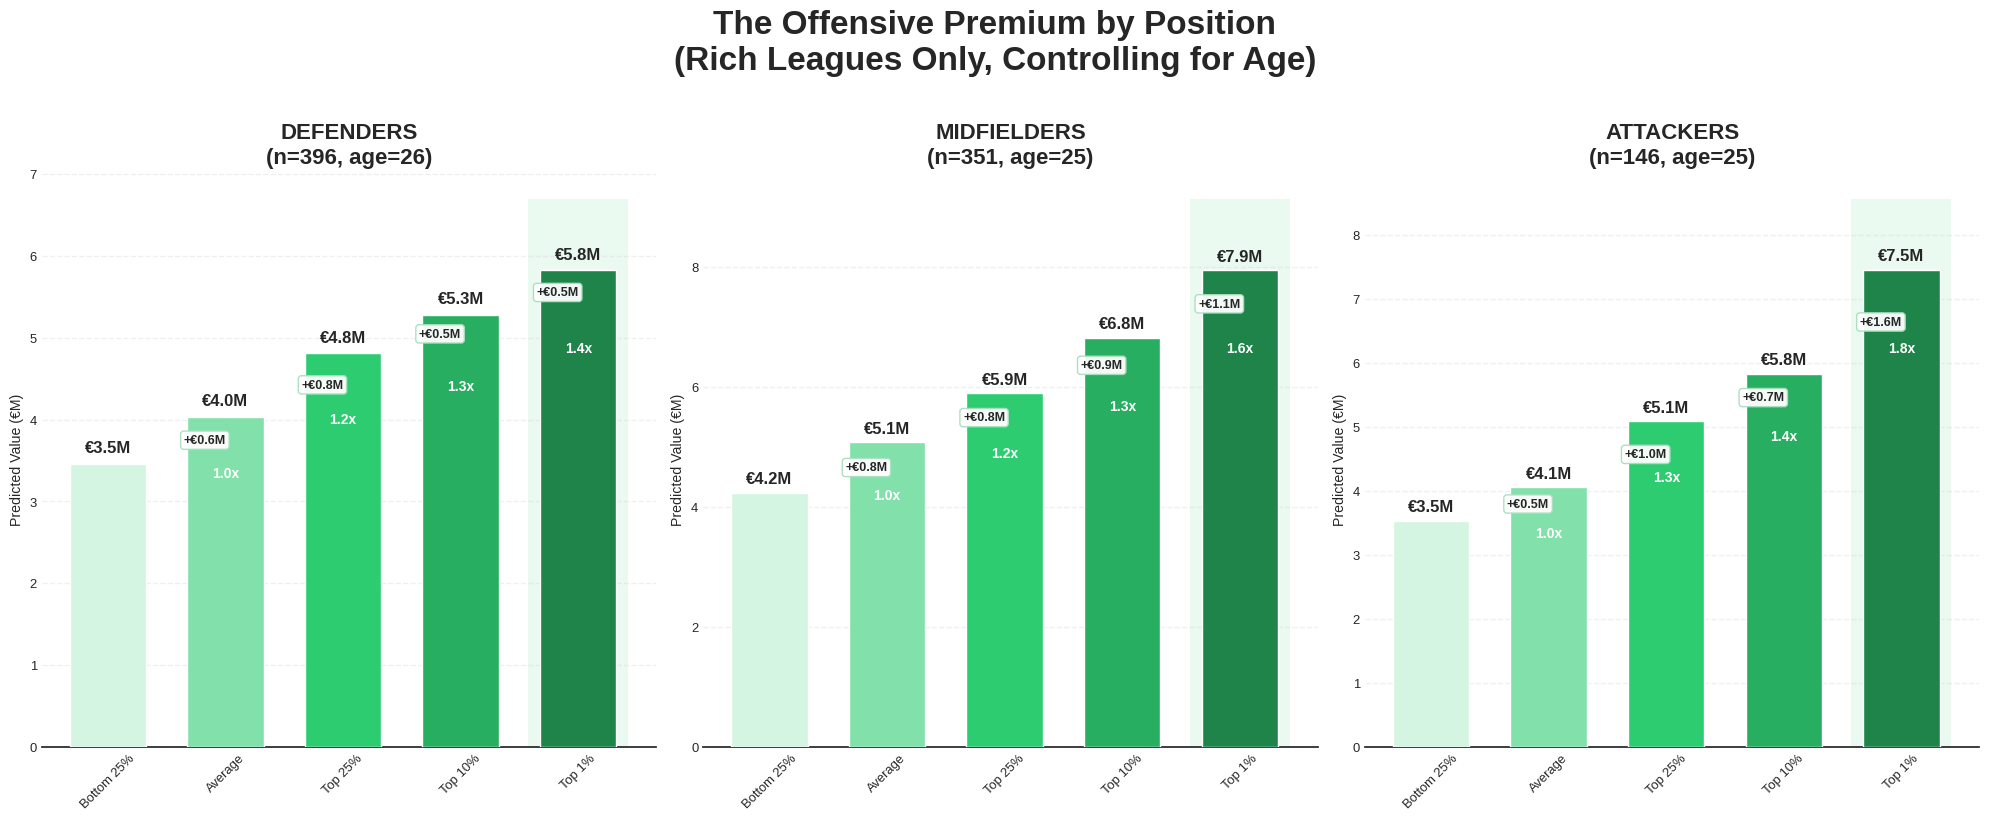


OFFENSIVE PREMIUM BY POSITION - EXECUTIVE SUMMARY
(Controlling for Age)

DEF (n=396, predicted at age 26)
--------------------------------------------------
  Bottom 25%:  €3.5M
  Average:     €4.0M
  Top 10%:     €5.3M
  Top 1%:      €5.8M
  Elite premium (Top 1% vs Average): 1.4x (+€1.8M)
  Value unlocked (Bottom 25% → Average): +€0.57M

MID (n=351, predicted at age 25)
--------------------------------------------------
  Bottom 25%:  €4.2M
  Average:     €5.1M
  Top 10%:     €6.8M
  Top 1%:      €7.9M
  Elite premium (Top 1% vs Average): 1.6x (+€2.9M)
  Value unlocked (Bottom 25% → Average): +€0.84M

ATT (n=146, predicted at age 25)
--------------------------------------------------
  Bottom 25%:  €3.5M
  Average:     €4.1M
  Top 10%:     €5.8M
  Top 1%:      €7.5M
  Elite premium (Top 1% vs Average): 1.8x (+€3.4M)
  Value unlocked (Bottom 25% → Average): +€0.52M

CROSS-POSITION COMPARISON

Elite (Top 1%) values:
  DEF: €5.8M
  MID: €7.9M
  ATT: €7.5M

Biggest jump (Bottom 25% → To

In [187]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import statsmodels.api as sm

# ==========================================
# RICH / TOP LEAGUE FILTER
# ==========================================

TOP_LEAGUES = [
    "English Premier League",
    "Spain Primera Division",
    "German 1. Bundesliga",
    "Italian Serie A",
    "French Ligue 1",
    "Holland Eredivisie",
    "Portuguese Liga ZON SAGRES",
]

# ==========================================
# 1. COMPUTE OFFENSIVE PREMIUM BY FORMATION
# ==========================================

def compute_offensive_premium(df, formation=None):

    if formation:
        data = df[df['formation'] == formation].copy()
        label = formation.upper()
    else:
        data = df.copy()
        label = "ALL"

    data['dist_scaled'] = (
        data['dist_to_offensive_star']
        - data['dist_to_offensive_star'].mean()
    ) / data['dist_to_offensive_star'].std()

    data['log_value'] = np.log10(data['value_eur'])

    X = sm.add_constant(data[['dist_scaled', 'age']])
    y = data['log_value']
    model = sm.OLS(y, X, missing='drop').fit()

    median_age = data['age'].median()

    percentiles = [75, 50, 25, 10, 1]
    results = []

    for p in percentiles:
        dist = data['dist_to_offensive_star'].quantile(p / 100)
        dist_scaled = (
            dist - data['dist_to_offensive_star'].mean()
        ) / data['dist_to_offensive_star'].std()

        predicted_log = (
            model.params['const']
            + model.params['dist_scaled'] * dist_scaled
            + model.params['age'] * median_age
        )

        results.append({
            "percentile": p,
            "predicted_value": 10 ** predicted_log
        })

    return {
        "formation": label,
        "n_players": len(data),
        "median_age": median_age,
        "results": results,
        "values": [r["predicted_value"] / 1_000_000 for r in results]
    }


# ==========================================
# 2. PLOT OFFENSIVE PREMIUM BY FORMATION
# ==========================================

def plot_offensive_premium_by_formation(df):

    # ----------------------------------
    # TOP-LEAGUE SUBSET
    # ----------------------------------
    df = df[df["league_name"].isin(TOP_LEAGUES)].copy()

    formations = ["def", "mid", "att"]
    titles = {"def": "DEFENDERS", "mid": "MIDFIELDERS", "att": "ATTACKERS"}
    labels = ["Bottom 25%", "Average", "Top 25%", "Top 10%", "Top 1%"]

    colors = [
        "#D5F5E3",
        "#82E0AA",
        "#2ECC71",
        "#27AE60",
        "#1E8449"
    ]

    formation_data = {
        f: compute_offensive_premium(df, f)
        for f in formations
    }

    plt.style.use("seaborn-v0_8-white")
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    for idx, formation in enumerate(formations):

        ax = axes[idx]
        data = formation_data[formation]
        values = data["values"]
        n_players = data["n_players"]
        median_age = data["median_age"]

        bars = ax.bar(
            labels,
            values,
            color=colors,
            width=0.65,
            zorder=3
        )

        # ------------------------------
        # VALUE LABELS
        # ------------------------------
        for bar, val in zip(bars, values):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.1,
                f"€{val:.1f}M",
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold"
            )

        # ------------------------------
        # MULTIPLIERS VS AVERAGE
        # ------------------------------
        baseline = values[1]

        for i, (bar, val) in enumerate(zip(bars, values)):
            if i == 0:
                continue
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() * 0.85,
                f"{val / baseline:.1f}x",
                ha="center",
                va="top",
                fontsize=10,
                color="white",
                fontweight="bold"
            )

        # ------------------------------
        # DISCRETE JUMPS (IMPORTANT BIT)
        # ------------------------------
        for i in range(len(values) - 1):
            diff = values[i + 1] - values[i]

            x_mid = (
                bars[i].get_x()
                + bars[i].get_width()
                + (bars[i + 1].get_x() - bars[i].get_x()) / 2
            )

            y_mid = (values[i] + values[i + 1]) / 2

            ax.annotate(
                f"+€{diff:.1f}M",
                xy=(x_mid, y_mid),
                ha="center",
                va="center",
                fontsize=9,
                fontweight="bold",
                bbox=dict(
                    boxstyle="round,pad=0.25",
                    fc="white",
                    ec="#A9DFBF",
                    alpha=0.95
                )
            )

        # ------------------------------
        # ELITE HIGHLIGHT
        # ------------------------------
        elite = bars[-1]
        rect = patches.Rectangle(
            (elite.get_x() - 0.1, 0),
            elite.get_width() + 0.2,
            values[-1] * 1.15,
            facecolor="#EAFAF1",
            edgecolor="none",
            zorder=0
        )
        ax.add_patch(rect)

        ax.set_title(
            f"{titles[formation]}\n(n={n_players:,}, age={median_age:.0f})",
            fontsize=16,
            fontweight="bold"
        )

        ax.set_ylabel("Predicted Value (€M)")
        ax.grid(axis="y", linestyle="--", alpha=0.3)
        ax.spines[["top", "right", "left"]].set_visible(False)
        ax.tick_params(axis="x", rotation=45)

    plt.suptitle(
        "The Offensive Premium by Position\n(Rich Leagues Only, Controlling for Age)",
        fontsize=24,
        fontweight="bold",
        y=1.02
    )

    plt.tight_layout()
    plt.show()

    return formation_data


# ==========================================
# 3. USAGE
# ==========================================

formation_data = plot_offensive_premium_by_formation(analysis_df)
print_formation_summary(formation_data)


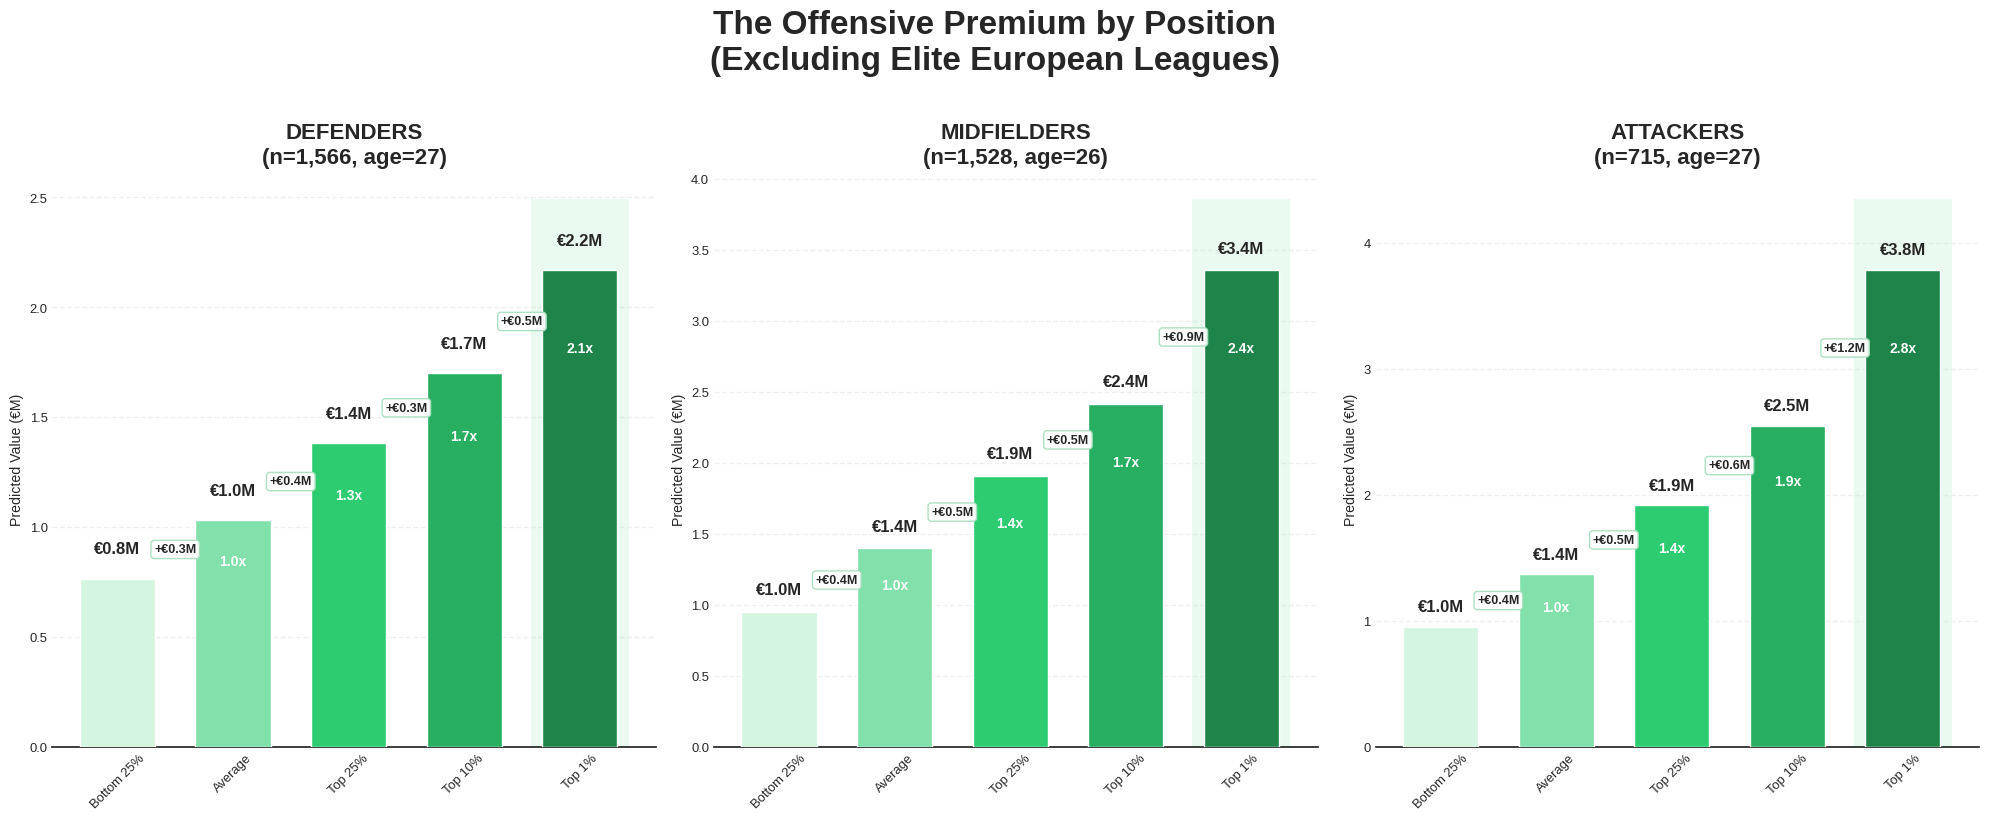


OFFENSIVE PREMIUM BY POSITION - EXECUTIVE SUMMARY
(Controlling for Age)

DEF (n=1,566, predicted at age 27)
--------------------------------------------------
  Bottom 25%:  €0.8M
  Average:     €1.0M
  Top 10%:     €1.7M
  Top 1%:      €2.2M
  Elite premium (Top 1% vs Average): 2.1x (+€1.1M)
  Value unlocked (Bottom 25% → Average): +€0.27M

MID (n=1,528, predicted at age 26)
--------------------------------------------------
  Bottom 25%:  €1.0M
  Average:     €1.4M
  Top 10%:     €2.4M
  Top 1%:      €3.4M
  Elite premium (Top 1% vs Average): 2.4x (+€2.0M)
  Value unlocked (Bottom 25% → Average): +€0.45M

ATT (n=715, predicted at age 27)
--------------------------------------------------
  Bottom 25%:  €1.0M
  Average:     €1.4M
  Top 10%:     €2.5M
  Top 1%:      €3.8M
  Elite premium (Top 1% vs Average): 2.8x (+€2.4M)
  Value unlocked (Bottom 25% → Average): +€0.42M

CROSS-POSITION COMPARISON

Elite (Top 1%) values:
  DEF: €2.2M
  MID: €3.4M
  ATT: €3.8M

Biggest jump (Bottom 25% 

In [200]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import statsmodels.api as sm

# ==========================================
# EXCLUDE ELITE EUROPEAN LEAGUES
# ==========================================

EXCLUDED_LEAGUES = [
    "English Premier League",
    "Spain Primera Division",
    "German 1. Bundesliga",
    "Italian Serie A",
    "French Ligue 1",
    "Saudi Abdul L. Jameel League"
]

# ==========================================
# 1. COMPUTE OFFENSIVE PREMIUM BY FORMATION
# ==========================================

def compute_offensive_premium(df, formation=None):

    if formation:
        data = df[df['formation'] == formation].copy()
        label = formation.upper()
    else:
        data = df.copy()
        label = "ALL"

    data['dist_scaled'] = (
        data['dist_to_offensive_star']
        - data['dist_to_offensive_star'].mean()
    ) / data['dist_to_offensive_star'].std()

    data['log_value'] = np.log10(data['value_eur'])

    X = sm.add_constant(data[['dist_scaled', 'age']])
    y = data['log_value']
    model = sm.OLS(y, X, missing='drop').fit()

    median_age = data['age'].median()

    percentiles = [75, 50, 25, 10, 1]
    results = []

    for p in percentiles:
        dist = data['dist_to_offensive_star'].quantile(p / 100)
        dist_scaled = (
            dist - data['dist_to_offensive_star'].mean()
        ) / data['dist_to_offensive_star'].std()

        predicted_log = (
            model.params['const']
            + model.params['dist_scaled'] * dist_scaled
            + model.params['age'] * median_age
        )

        results.append({
            "percentile": p,
            "predicted_value": 10 ** predicted_log
        })

    return {
        "formation": label,
        "n_players": len(data),
        "median_age": median_age,
        "results": results,
        "values": [r["predicted_value"] / 1_000_000 for r in results]
    }


# ==========================================
# 2. PLOT OFFENSIVE PREMIUM BY FORMATION
# ==========================================

def plot_offensive_premium_by_formation(df):

    # ----------------------------------
    # REMOVE BIG EURO LEAGUES
    # ----------------------------------
    df = df[~df["league_name"].isin(EXCLUDED_LEAGUES)].copy()

    formations = ["def", "mid", "att"]
    titles = {"def": "DEFENDERS", "mid": "MIDFIELDERS", "att": "ATTACKERS"}
    labels = ["Bottom 25%", "Average", "Top 25%", "Top 10%", "Top 1%"]

    colors = [
        "#D5F5E3",
        "#82E0AA",
        "#2ECC71",
        "#27AE60",
        "#1E8449"
    ]

    formation_data = {
        f: compute_offensive_premium(df, f)
        for f in formations
    }

    plt.style.use("seaborn-v0_8-white")
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    for idx, formation in enumerate(formations):

        ax = axes[idx]
        data = formation_data[formation]
        values = data["values"]
        n_players = data["n_players"]
        median_age = data["median_age"]

        bars = ax.bar(
            labels,
            values,
            color=colors,
            width=0.65,
            zorder=3
        )

        # value labels
        for bar, val in zip(bars, values):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.1,
                f"€{val:.1f}M",
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold"
            )

        # multipliers
        baseline = values[1]
        for i, (bar, val) in enumerate(zip(bars, values)):
            if i == 0:
                continue
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() * 0.85,
                f"{val / baseline:.1f}x",
                ha="center",
                va="top",
                fontsize=10,
                color="white",
                fontweight="bold"
            )

        # discrete jumps
        for i in range(len(values) - 1):
            diff = values[i + 1] - values[i]
            y_mid = (values[i] + values[i + 1]) / 2

            ax.annotate(
                f"+€{diff:.1f}M",
                xy=(i + 0.5, y_mid),
                ha="center",
                va="center",
                fontsize=9,
                fontweight="bold",
                bbox=dict(
                    boxstyle="round,pad=0.25",
                    fc="white",
                    ec="#A9DFBF",
                    alpha=0.95
                )
            )

        # elite highlight
        elite = bars[-1]
        rect = patches.Rectangle(
            (elite.get_x() - 0.1, 0),
            elite.get_width() + 0.2,
            values[-1] * 1.15,
            facecolor="#EAFAF1",
            edgecolor="none",
            zorder=0
        )
        ax.add_patch(rect)

        ax.set_title(
            f"{titles[formation]}\n(n={n_players:,}, age={median_age:.0f})",
            fontsize=16,
            fontweight="bold"
        )

        ax.set_ylabel("Predicted Value (€M)")
        ax.grid(axis="y", linestyle="--", alpha=0.3)
        ax.spines[["top", "right", "left"]].set_visible(False)
        ax.tick_params(axis="x", rotation=45)

    plt.suptitle(
        "The Offensive Premium by Position\n(Excluding Elite European Leagues)",
        fontsize=24,
        fontweight="bold",
        y=1.02
    )

    plt.tight_layout()
    plt.show()

    return formation_data


# ==========================================
# 3. USAGE
# ==========================================

formation_data = plot_offensive_premium_by_formation(analysis_df)
print_formation_summary(formation_data)


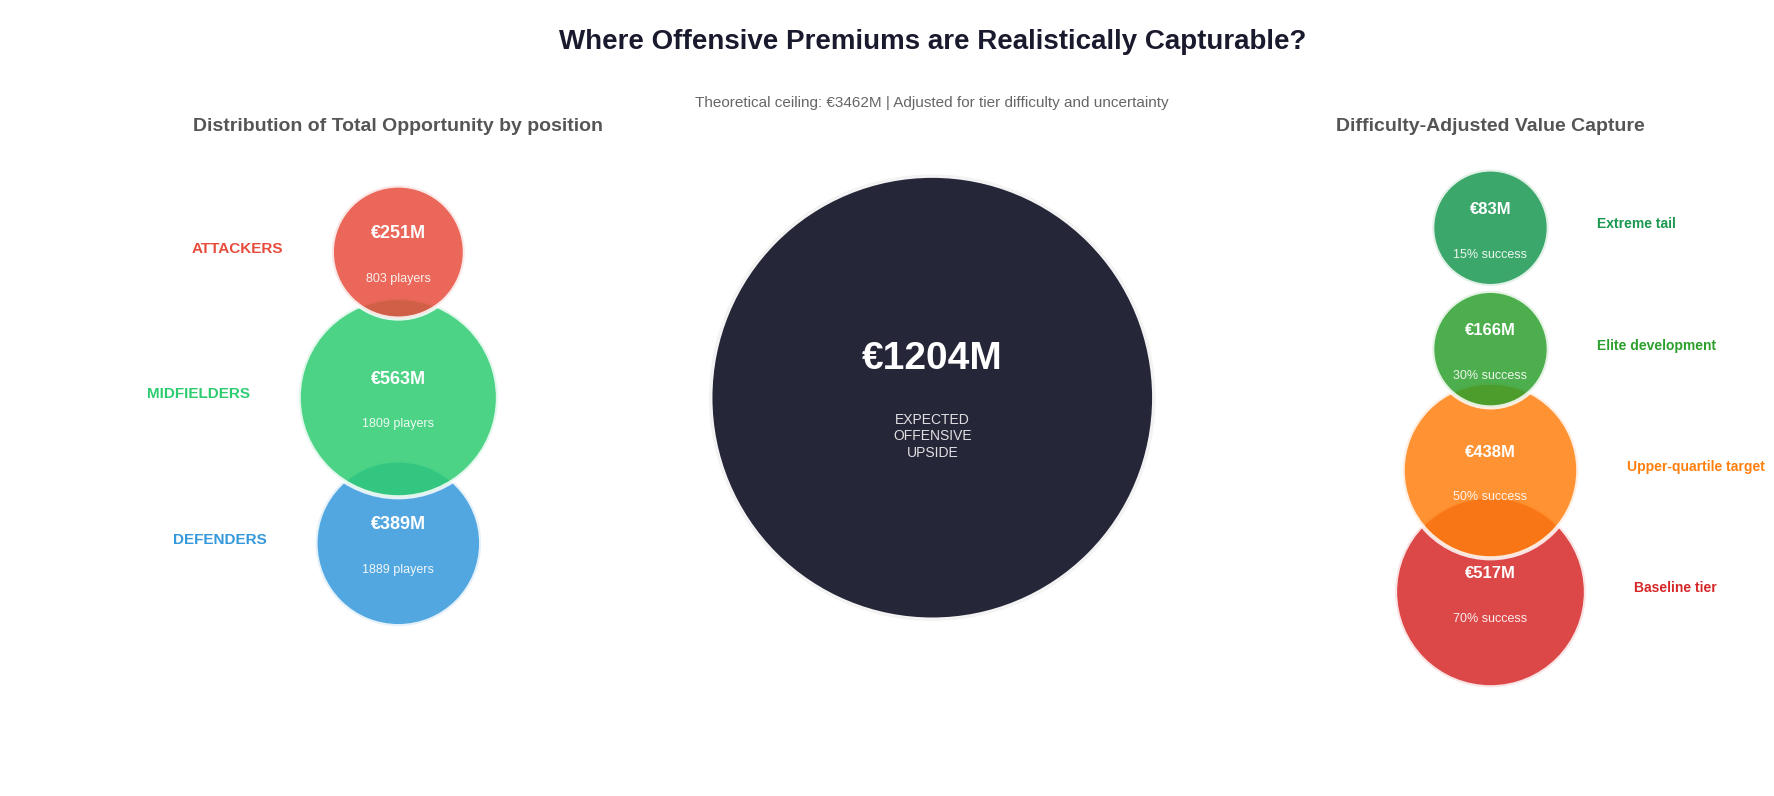

In [184]:
# ============================================================
# REALISTIC OFFENSIVE PREMIUM — EXPECTED VALUE SCENARIO
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Assumed tier success probabilities
# (illustrative — not predictive)
# ------------------------------------------------------------
TIER_SUCCESS_RATES = {
    "Average": 0.70,
    "Top 25%": 0.50,
    "Top 10%": 0.30,
    "Top 1%": 0.15
}

# ------------------------------------------------------------
# Build offensive premium summaries
# ------------------------------------------------------------
formation_summary, tier_summary, tagged_df = get_offensive_premium_summary(analysis_df)

# ============================================================
# TIER-LEVEL EXPECTED VALUE
# ============================================================

tier_premium = (
    tagged_df[tagged_df["target_tier"] != "CAPPED"]
    .groupby("target_tier")
    .agg(
        premium=("tier_premium_eur", "first"),
        count=("tier_premium_eur", "count")
    )
)

tier_premium["total_premium_eur"] = tier_premium["premium"] * tier_premium["count"]
tier_premium["premium_millions"] = tier_premium["total_premium_eur"] / 1e6
tier_premium["success_rate"] = tier_premium.index.map(TIER_SUCCESS_RATES)

tier_premium["expected_premium"] = (
    tier_premium["premium_millions"] * tier_premium["success_rate"]
)

tier_premium["share"] = (
    tier_premium["expected_premium"]
    / tier_premium["expected_premium"].sum()
)

# ============================================================
# POSITION-LEVEL EXPECTED VALUE
# ============================================================

formation_premium = (
    tagged_df[tagged_df["target_tier"] != "CAPPED"]
    .groupby("formation")
    .agg(
        total_premium_eur=("tier_premium_eur", "sum"),
        count=("tier_premium_eur", "count")
    )
)

formation_premium["premium_millions"] = (
    formation_premium["total_premium_eur"] / 1e6
)

def expected_premium_by_position(df, formation):
    subset = df[(df["formation"] == formation) & (df["target_tier"] != "CAPPED")]
    expected = 0
    for tier, rate in TIER_SUCCESS_RATES.items():
        expected += subset[subset["target_tier"] == tier]["tier_premium_eur"].sum() * rate
    return expected / 1e6

for pos in ["def", "mid", "att"]:
    formation_premium.loc[pos, "expected_premium"] = (
        expected_premium_by_position(tagged_df, pos)
    )

formation_premium["share"] = (
    formation_premium["expected_premium"]
    / formation_premium["expected_premium"].sum()
)

total_theoretical = tier_premium["premium_millions"].sum()
total_expected = tier_premium["expected_premium"].sum()

# ============================================================
# VISUALISATION — BUBBLE SUMMARY
# ============================================================

# ------------------------------------------------------------
# Bubble size constraints (Fix 1)
# ------------------------------------------------------------
MIN_RADIUS = 0.12
MAX_RADIUS = 0.32

fig, ax = plt.subplots(figsize=(18, 10))
ax.set_xlim(-0.4, 3.1)
ax.set_ylim(-0.2, 1.4)
ax.set_aspect("equal")
ax.axis("off")

# ------------------------------------------------------------
# LEFT: BY POSITION
# ------------------------------------------------------------
formation_colors = {
    "def": "#3498db",
    "mid": "#2ecc71",
    "att": "#e74c3c"
}

formation_labels = {
    "def": "DEFENDERS",
    "mid": "MIDFIELDERS",
    "att": "ATTACKERS"
}

formation_order = ["def", "mid", "att"]
y_positions = [0.30, 0.60, 0.90]
x_left = 0.4

ax.text(
    x_left, 1.15,
    "Distribution of Total Opportunity by position",
    ha="center", fontsize=14,
    fontweight="bold", color="#555"
)

for pos, y in zip(formation_order, y_positions):

    row = formation_premium.loc[pos]

    radius = np.clip(
        np.sqrt(row["share"]) * 0.30,
        MIN_RADIUS,
        MAX_RADIUS
    )

    ax.add_patch(
        plt.Circle(
            (x_left, y),
            radius,
            color=formation_colors[pos],
            alpha=0.85,
            ec="white",
            lw=3
        )
    )

    ax.text(
        x_left, y + 0.03,
        f"€{row['expected_premium']:.0f}M",
        ha="center",
        fontsize=13,
        fontweight="bold",
        color="white"
    )

    ax.text(
        x_left, y - 0.06,
        f"{int(row['count'])} players",
        ha="center",
        fontsize=9,
        color="white",
        alpha=0.9
    )

    ax.text(
        x_left - radius - 0.10,
        y,
        formation_labels[pos],
        ha="right",
        fontsize=11,
        fontweight="bold",
        color=formation_colors[pos]
    )

# ------------------------------------------------------------
# CENTER: TOTAL EXPECTED PREMIUM
# ------------------------------------------------------------
ax.add_patch(
    plt.Circle(
        (1.5, 0.6),
        0.46,
        color="#1a1a2e",
        alpha=0.95,
        ec="white",
        lw=5
    )
)

ax.text(
    1.5, 0.66,
    f"€{total_expected:.0f}M",
    ha="center",
    fontsize=28,
    fontweight="bold",
    color="white"
)

ax.text(
    1.5, 0.48,
    "EXPECTED\nOFFENSIVE\nUPSIDE",
    ha="center",
    fontsize=10,
    color="white",
    alpha=0.85
)

# ------------------------------------------------------------
# RIGHT: BY TARGET TIER
# ------------------------------------------------------------
tier_order = ["Average", "Top 25%", "Top 10%", "Top 1%"]
tier_colors = ["#d62728", "#ff7f0e", "#2ca02c", "#1a9850"]

tier_labels = {
    "Average": "Baseline tier",
    "Top 25%": "Upper-quartile target",
    "Top 10%": "Elite development",
    "Top 1%": "Extreme tail"
}

x_right = 2.65
y_tiers = [0.20, 0.45, 0.70, 0.95]

ax.text(
    x_right, 1.15,
    "Difficulty-Adjusted Value Capture",
    ha="center",
    fontsize=14,
    fontweight="bold",
    color="#555"
)

for tier, color, y in zip(tier_order, tier_colors, y_tiers):

    row = tier_premium.loc[tier]

    radius = np.clip(
        np.sqrt(row["share"]) * 0.30,
        MIN_RADIUS,
        MAX_RADIUS
    )

    ax.add_patch(
        plt.Circle(
            (x_right, y),
            radius,
            color=color,
            alpha=0.85,
            ec="white",
            lw=3
        )
    )

    ax.text(
        x_right, y + 0.03,
        f"€{row['expected_premium']:.0f}M",
        ha="center",
        fontsize=12,
        fontweight="bold",
        color="white"
    )

    ax.text(
        x_right, y - 0.06,
        f"{int(row['success_rate']*100)}% success",
        ha="center",
        fontsize=9,
        color="white",
        alpha=0.9
    )

    ax.text(
        x_right + radius + 0.10,
        y,
        tier_labels[tier],
        ha="left",
        fontsize=10,
        fontweight="bold",
        color=color
    )

# ------------------------------------------------------------
# TITLES
# ------------------------------------------------------------
ax.text(
    1.5, 1.32,
    "Where Offensive Premiums are Realistically Capturable?",
    ha="center",
    fontsize=20,
    fontweight="bold",
    color="#1a1a2e"
)

ax.text(
    1.5, 1.20,
    f"Theoretical ceiling: €{total_theoretical:.0f}M | "
    "Adjusted for tier difficulty and uncertainty",
    ha="center",
    fontsize=11,
    color="#666"
)

plt.tight_layout()
plt.show()


## Where Offensive Premiums Are Realistically Capturable

This slide answers a single question:

**Where can offensive market value actually be captured once development difficulty and uncertainty are taken into account?**

Rather than focusing on theoretical maximum player values, the analysis reframes the problem in expected-value terms — combining the size of potential upside with the probability of successfully reaching it.

---

### **Left panel — Distribution of total opportunity**

The left side shows how offensive upside is distributed across positions.

- **Midfielders** represent the largest pool of opportunity, driven primarily by volume — there are simply more midfield players in the market.
- **Defenders** still offer meaningful offensive upside, but with a structurally lower ceiling.
- **Attackers** exhibit the highest individual upside, though across a smaller population.

This separates **where value exists** from **how difficult it is to realise**.

---

### **Center — Expected offensive upside**

The central bubble aggregates all positions and tiers into a single expected-value estimate.

- The €1.2bn figure is **not a forecast**.
- It represents expected upside after adjusting the theoretical ceiling for:
  - tier difficulty  
  - uncertainty in development outcomes  

This reframes valuation from *maximum potential* to *realistically attainable value*.

---

### **Right panel — Difficulty-adjusted value capture**

The right side explains why expected value concentrates where it does.

As players move up the performance distribution:

- potential value rises sharply  
- probability of success declines rapidly  

Although the **Top 1% tier** carries extreme individual upside, only a small fraction of that value is realistically captured.

In contrast:

- baseline and upper-quartile tiers  
- offer lower ceilings  
- but substantially higher success probabilities  

As a result, the majority of expected value comes from **achievable improvement**, not from chasing rare superstar outcomes.

---

### **Key insight**

> **Markets reward elite offensive output — but most monetisable value lies below the extreme tail.**

From an optimisation perspective:

- star-hunting is high-variance  
- systematic development toward upper tiers delivers far more reliable returns  

---

### **Why this matters**

This framework mirrors portfolio-optimisation logic:

- players differ in payoff magnitude  
- success probabilities vary sharply by tier  
- optimal value capture lies where scale and likelihood intersect  

Rather than treating player valuation as a single regression problem, the analysis explicitly models **heterogeneous mechanisms, nonlinear rewards, and asymmetric risk**.

---

**In short:**  
Elite players drive headlines — but expected market value is created by consistently moving large populations closer to what the market rewards.


The €256M figure should be interpreted as the total expected valuation reallocation available under the current market configuration. It reflects a one-cycle development opportunity rather than a recurring annual gain, and would dissipate as prices adjust and skill distributions shift.

SCOUT REPORT: English Premier League

SQUAD OVERVIEW
   Developable players: 39
   Elite (capped): 2

OFFENSIVE PREMIUM VALUE
   Theoretical upside: €29.46M
   Expected value: €21.06M
   Expected net profit: €17.16M

POSITION-SPECIFIC TRAINING PRIORITIES

DEFENDERS (13 players)
--------------------------------------------------
   Skill weights: {'dribbling': 2.0, 'shooting': 0.1, 'passing': 1}
   Training priorities:
      SHOOTING: 9 priority points
         (raw gap: 94 × weight: 0.1)
      PASSING: 9 priority points
         (raw gap: 9 × weight: 1)
      DRIBBLING: 6 priority points
         (raw gap: 3 × weight: 2.0)

MIDFIELDERS (19 players)
--------------------------------------------------
   Skill weights: {'dribbling': 2.0, 'passing': 1.2, 'shooting': 1.0}
   Training priorities:
      SHOOTING: 30 priority points
         (raw gap: 30 × weight: 1.0)
      DRIBBLING: 12 priority points
         (raw gap: 6 × weight: 2.0)
      PASSING: 10 priority points
         (raw gap: 8

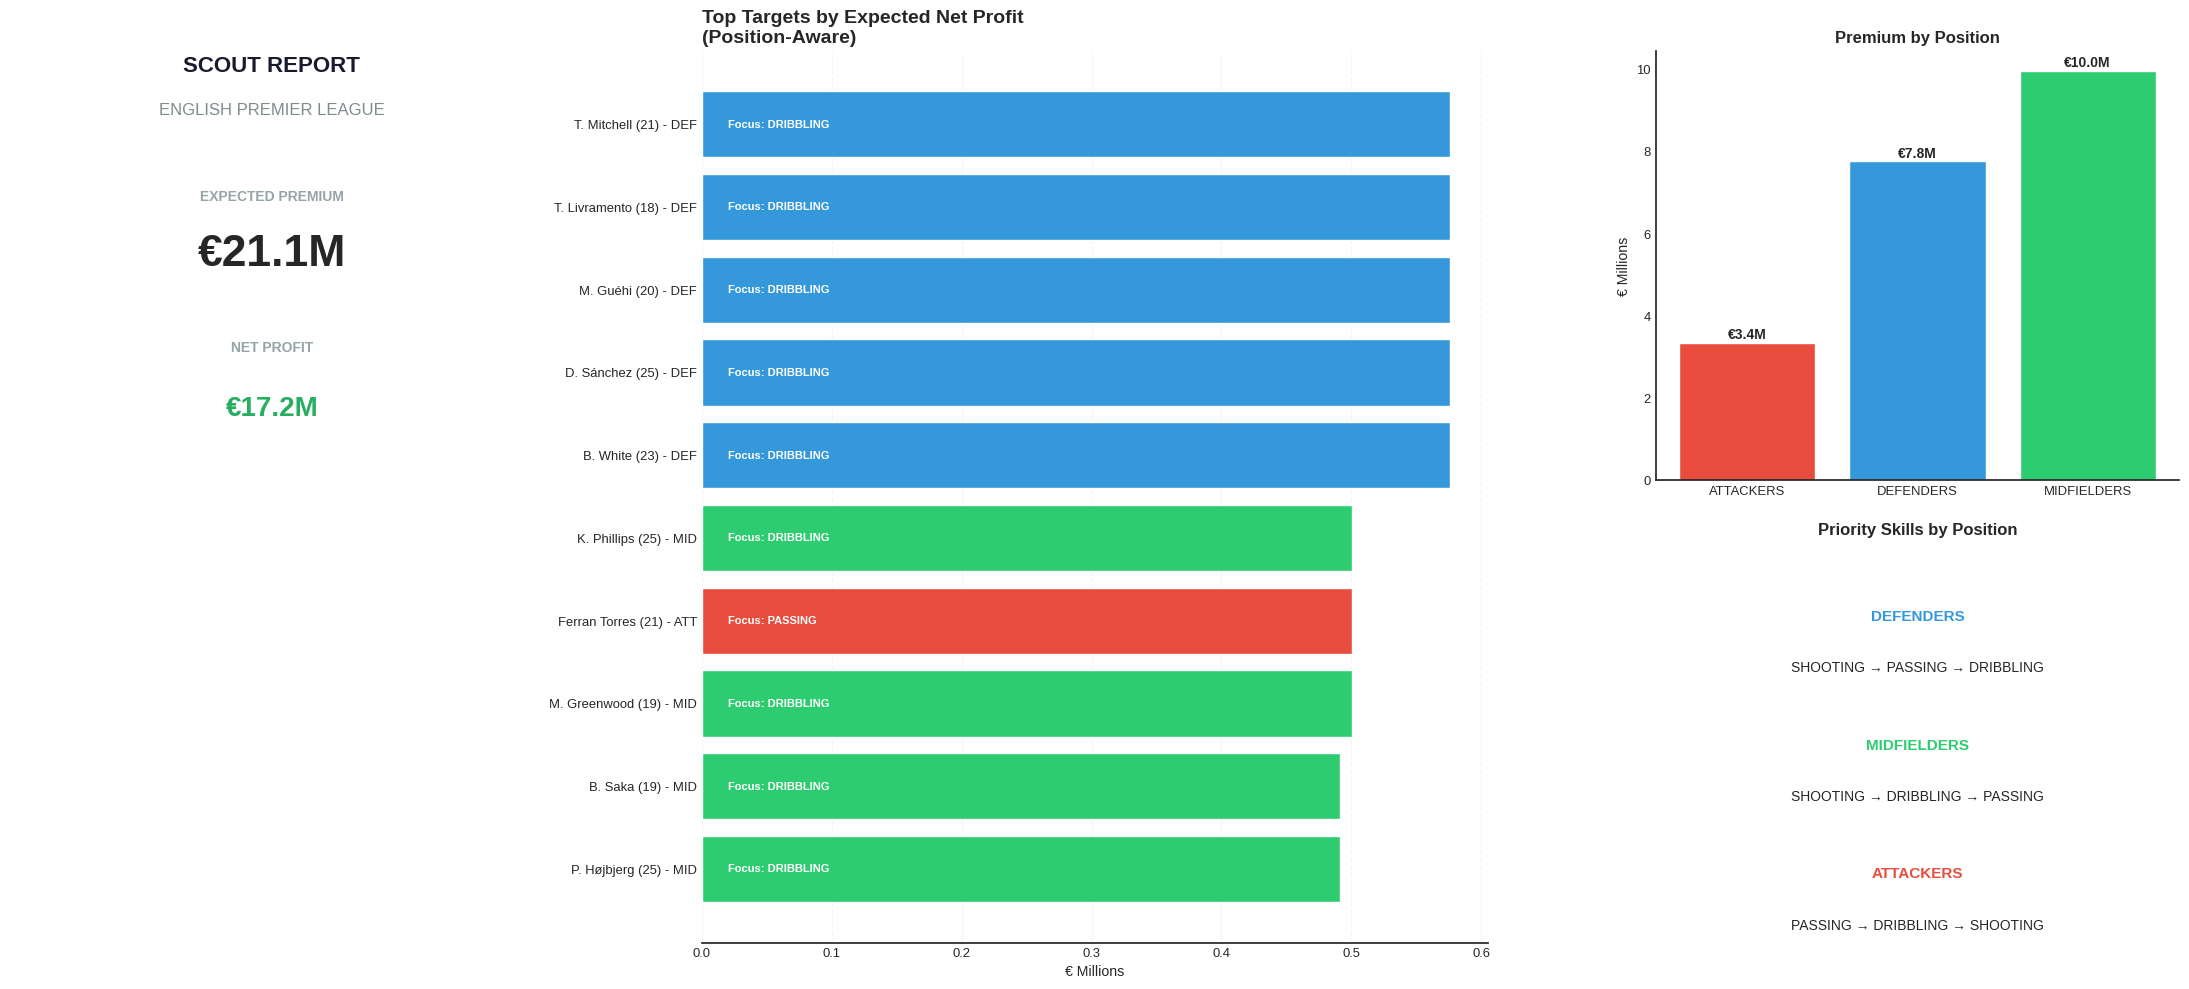

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# CONFIGURATION
# ============================================================

TIER_COLORS = {
    'Top 1%': '#2ecc71',
    'Top 10%': '#27ae60',
    'Top 25%': '#f1c40f',
    'Average': '#e74c3c',
    'Bottom 25%': '#c0392b',
    'CAPPED': '#95a5a6'
}

TIER_DISPLAY_NAMES = {
    'Bottom 25%': 'Train to a basic professional standard',
    'Average': 'Train to an average standard of play',
    'Top 25%': 'Train to a good standard of play',
    'Top 10%': 'Train to an elite standard of play',
    'Top 1%': 'Train to a world-class standard of play'
}

TIER_SUCCESS_RATES = {
    'Bottom 25%': 0.80,
    'Average': 0.70,
    'Top 25%': 0.60,
    'Top 10%': 0.40,
    'Top 1%': 0.30
}

# ============================================================
# POSITION-SPECIFIC SKILL WEIGHTS (from SHAP analysis)
# ============================================================

FORMATION_SKILL_WEIGHTS = {
    'def': {
        'dribbling': 2.0,
        'shooting': 0.1,
        'passing': 1
    },
    'mid': {
        'dribbling': 2.0,
        'passing': 1.2,
        'shooting': 1.0
    },
    'att': {
        'passing': 2.0,
        'dribbling': 1,
        'shooting': 1
    }
}

FORMATION_DISPLAY_NAMES = {
    'def': 'DEFENDERS',
    'mid': 'MIDFIELDERS',
    'att': 'ATTACKERS'
}


# ============================================================
# CORE MODEL (Position-Aware)
# ============================================================

def scout_development_opportunities(
    df,
    distance_col='dist_to_offensive_star',
    formation_col='formation',
    club=None,
    league=None,
    max_age=30,
    min_potential=60,
    min_pace=65,
    development_cost=100_000,
    top_n=20,
    offensive_skills=['dribbling', 'passing', 'shooting'],
    base_trainability=None,
    tier_success_rates=None,
    formation_skill_weights=None
):
    """
    Position-aware scout model.
    
    Applies different skill weights for defenders, midfielders, and attackers
    based on SHAP analysis of what drives value for each position.
    """

    if base_trainability is None:
        base_trainability = {
            'dribbling': 0.7,
            'passing': 0.8,
            'shooting': 0.7
        }

    if tier_success_rates is None:
        tier_success_rates = TIER_SUCCESS_RATES

    if formation_skill_weights is None:
        formation_skill_weights = FORMATION_SKILL_WEIGHTS

    # --------------------------------------------------------
    # 1. Filter data
    # --------------------------------------------------------
    filtered_df = df.copy()
    filter_name = "All Players"

    if club:
        filtered_df = filtered_df[filtered_df['club_name'] == club]
        filter_name = club
    elif league:
        filtered_df = filtered_df[filtered_df['league_name'] == league]
        filter_name = league

    if len(filtered_df) == 0:
        return {"error": f"No players found for {filter_name}"}

    # --------------------------------------------------------
    # 2. Tier tagging
    # --------------------------------------------------------
    tagged_df = tag_player_tiers(filtered_df, distance_col)

    # --------------------------------------------------------
    # 3. Developable players
    # --------------------------------------------------------
    developable = tagged_df[
        (tagged_df['target_tier'] != 'CAPPED') &
        (tagged_df['age'] <= max_age) &
        (tagged_df['potential'] >= min_potential) &
        (tagged_df['pace'] >= min_pace)
    ].copy()

    if len(developable) == 0:
        return {"error": "No developable players found", "filter": filter_name}

    # --------------------------------------------------------
    # 4. Skill gaps vs target standard
    # --------------------------------------------------------
    thresholds = {
        'Top 1%': df[distance_col].quantile(0.01),
        'Top 10%': df[distance_col].quantile(0.10),
        'Top 25%': df[distance_col].quantile(0.25),
        'Average': df[distance_col].quantile(0.50)
    }

    tier_profiles = {}
    for tier, threshold in thresholds.items():
        tier_players = df[df[distance_col] <= threshold]
        tier_profiles[tier] = tier_players[offensive_skills].mean()

    for skill in offensive_skills:
        developable[f'{skill}_gap'] = developable.apply(
            lambda row: max(
                0,
                tier_profiles.get(row['target_tier'], {}).get(skill, 0)
                - row[skill]
            ),
            axis=1
        )

    # --------------------------------------------------------
    # 5. Position-specific skill weights
    # --------------------------------------------------------
    def get_player_skill_weight(row, skill):
        formation = row[formation_col]
        if formation in formation_skill_weights:
            return formation_skill_weights[formation].get(skill, 1.0)
        return 1.0

    for skill in offensive_skills:
        developable[f'{skill}_weight'] = developable.apply(
            lambda row: get_player_skill_weight(row, skill), axis=1
        )
        developable[f'{skill}_weighted_gap'] = (
            developable[f'{skill}_gap'] * developable[f'{skill}_weight']
        )

    # --------------------------------------------------------
    # 6. Position-aware value multiplier
    # --------------------------------------------------------
    # Players with higher weighted skill alignment get boosted returns
    developable['total_weighted_gap'] = sum(
        developable[f'{skill}_weighted_gap'] for skill in offensive_skills
    )
    
    developable['total_raw_gap'] = sum(
        developable[f'{skill}_gap'] for skill in offensive_skills
    )
    
    # Alignment score: how well does the player's gap profile match their position needs?
    # Lower is better (smaller gaps in high-weight skills)
    gap_max = developable['total_weighted_gap'].max()
    developable['position_alignment'] = 1 - (developable['total_weighted_gap'] / (gap_max + 1e-6))

    # --------------------------------------------------------
    # 7. Effort + expected value
    # --------------------------------------------------------
    pot_min, pot_max = df['potential'].min(), df['potential'].max()

    developable['potential_modifier'] = (
        0.5 + (developable['potential'] - pot_min) / (pot_max - pot_min)
    )

    developable['effort_to_target'] = sum(
        developable[f'{skill}_gap'] * (1 / base_trainability[skill])
        for skill in offensive_skills
    )

    developable['success_rate'] = developable['target_tier'].map(tier_success_rates)

    developable['base_expected_return_eur'] = (
        developable['tier_premium_eur'] * developable['success_rate']
    )
    
    # Position alignment boosts expected return
    developable['expected_return_eur'] = (
        developable['base_expected_return_eur'] * (1 + 0.3 * developable['position_alignment'])
    )

    developable['net_profit_eur'] = (
        developable['expected_return_eur'] - development_cost
    )

    developable['profit_if_successful'] = (
        developable['tier_premium_eur'] - development_cost
    )

    effort_norm = (
        (developable['effort_to_target'] - developable['effort_to_target'].min()) /
        (developable['effort_to_target'].max() -
         developable['effort_to_target'].min() + 1e-6)
    )

    developable['priority_score'] = (
        developable['potential_modifier']
        * developable['success_rate']
        * (1 + 0.3 * developable['position_alignment'])
        * (1 - effort_norm)
        * (developable['tier_premium_eur'] /
           developable['tier_premium_eur'].max())
    )

    # --------------------------------------------------------
    # 8. Training priorities by formation
    # --------------------------------------------------------
    training_priorities_by_formation = {}
    
    for formation in ['def', 'mid', 'att']:
        formation_players = developable[developable[formation_col] == formation]
        if len(formation_players) == 0:
            continue
            
        weights = formation_skill_weights.get(formation, {})
        
        raw_gaps = {
            skill: formation_players[f'{skill}_gap'].sum()
            for skill in offensive_skills
        }
        
        weighted_gaps = {
            skill: raw_gaps[skill] * weights.get(skill, 1.0)
            for skill in offensive_skills
        }
        
        training_priorities_by_formation[formation] = {
            'raw_gaps': raw_gaps,
            'weighted_gaps': weighted_gaps,
            'priorities': sorted(weighted_gaps.items(), key=lambda x: x[1], reverse=True),
            'player_count': len(formation_players),
            'weights': weights
        }

    # --------------------------------------------------------
    # 9. Outputs
    # --------------------------------------------------------
    top_candidates = developable.nlargest(top_n, 'priority_score')

    tier_breakdown = developable.groupby('target_tier').agg(
        count=('short_name', 'count'),
        total_premium=('tier_premium_eur', 'sum'),
        total_expected=('expected_return_eur', 'sum'),
        avg_success_rate=('success_rate', 'mean')
    ).reset_index()

    tier_breakdown['premium_m'] = tier_breakdown['total_premium'] / 1e6
    tier_breakdown['expected_premium_m'] = tier_breakdown['total_expected'] / 1e6

    formation_breakdown = developable.groupby(formation_col).agg(
        count=('short_name', 'count'),
        total_premium=('tier_premium_eur', 'sum'),
        total_expected=('expected_return_eur', 'sum'),
        avg_alignment=('position_alignment', 'mean')
    ).reset_index()

    formation_breakdown['premium_m'] = formation_breakdown['total_premium'] / 1e6
    formation_breakdown['expected_premium_m'] = formation_breakdown['total_expected'] / 1e6

    return {
        'filter': filter_name,
        'total_premium_eur_m': developable['tier_premium_eur'].sum() / 1e6,
        'total_expected_premium_eur_m': developable['expected_return_eur'].sum() / 1e6,
        'total_net_profit_eur_m': developable['net_profit_eur'].sum() / 1e6,
        'tier_breakdown': tier_breakdown,
        'formation_breakdown': formation_breakdown,
        'training_priorities_by_formation': training_priorities_by_formation,
        'top_candidates': top_candidates,
        'developable_count': len(developable),
        'elite_count': len(tagged_df[tagged_df['target_tier'] == 'CAPPED']),
        'tier_success_rates': tier_success_rates,
        'formation_skill_weights': formation_skill_weights
    }


# ============================================================
# REPORT PRINTING
# ============================================================

def print_scout_report(report):
    if 'error' in report:
        print(f"ERROR: {report['error']}")
        return

    print("=" * 70)
    print(f"SCOUT REPORT: {report['filter']}")
    print("=" * 70)

    print("\nSQUAD OVERVIEW")
    print(f"   Developable players: {report['developable_count']}")
    print(f"   Elite (capped): {report['elite_count']}")

    print("\nOFFENSIVE PREMIUM VALUE")
    print(f"   Theoretical upside: €{report['total_premium_eur_m']:.2f}M")
    print(f"   Expected value: €{report['total_expected_premium_eur_m']:.2f}M")
    print(f"   Expected net profit: €{report['total_net_profit_eur_m']:.2f}M")

    print("\n" + "=" * 70)
    print("POSITION-SPECIFIC TRAINING PRIORITIES")
    print("=" * 70)
    
    for formation in ['def', 'mid', 'att']:
        if formation not in report['training_priorities_by_formation']:
            continue
            
        data = report['training_priorities_by_formation'][formation]
        display_name = FORMATION_DISPLAY_NAMES.get(formation, formation.upper())
        
        print(f"\n{display_name} ({data['player_count']} players)")
        print("-" * 50)
        print(f"   Skill weights: {data['weights']}")
        print(f"   Training priorities:")
        
        for skill, weighted_gap in data['priorities']:
            raw_gap = data['raw_gaps'][skill]
            weight = data['weights'].get(skill, 1.0)
            print(f"      {skill.upper()}: {int(weighted_gap)} priority points")
            print(f"         (raw gap: {int(raw_gap)} × weight: {weight})")

    print("\n" + "=" * 70)
    print("TOP DEVELOPMENT TARGETS")
    print("=" * 70)

    for _, row in report["top_candidates"].head(10).iterrows():
        formation = row.get('formation', 'unknown')
        display_formation = FORMATION_DISPLAY_NAMES.get(formation, formation.upper())
        
        print(f"\n{row['short_name']} ({int(row['age'])}y) - {display_formation}")
        print(
            f"   Target: "
            f"{TIER_DISPLAY_NAMES.get(row['target_tier'], row['target_tier'])} "
            f"({int(row['success_rate'] * 100)}% success)"
        )
        print(f"   Position alignment: {row['position_alignment']:.2f}")
        print(f"   Effort required: {row['effort_to_target']:.1f}")
        print(
            f"   Expected profit: €{row['net_profit_eur']/1e6:.2f}M "
            f"(€{row['profit_if_successful']/1e6:.2f}M if successful)"
        )
        
        # Show position-specific training recommendation
        if formation in report['formation_skill_weights']:
            weights = report['formation_skill_weights'][formation]
            top_skill = max(weights, key=weights.get)
            print(f"   Priority skill: {top_skill.upper()}")


# ============================================================
# REPORT PLOTTING
# ============================================================

def plot_scout_report(report):
    if 'error' in report:
        print(report['error'])
        return

    fig = plt.figure(figsize=(22, 10))
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1.5, 1])

    ax_kpi = fig.add_subplot(gs[0, 0])
    ax_players = fig.add_subplot(gs[:, 1])
    ax_formation = fig.add_subplot(gs[0, 2])
    ax_skills = fig.add_subplot(gs[1, 2])

    # ---------------- KPI PANEL ----------------
    ax_kpi.axis("off")

    ax_kpi.text(0.5, 0.95, f"SCOUT REPORT", transform=ax_kpi.transAxes,
                fontsize=16, weight="bold", color="#1a1a2e", ha="center")
    ax_kpi.text(0.5, 0.85, report['filter'].upper(), transform=ax_kpi.transAxes,
                fontsize=12, color="#7f8c8d", ha="center")

    ax_kpi.text(0.5, 0.65, "EXPECTED PREMIUM", transform=ax_kpi.transAxes,
                fontsize=10, weight="bold", color="#95a5a6", ha="center")
    ax_kpi.text(0.5, 0.50, f"€{report['total_expected_premium_eur_m']:.1f}M", 
                transform=ax_kpi.transAxes,
                fontsize=32, weight="bold", ha="center")

    ax_kpi.text(0.5, 0.30, "NET PROFIT", transform=ax_kpi.transAxes,
                fontsize=10, weight="bold", color="#95a5a6", ha="center")
    ax_kpi.text(0.5, 0.15, f"€{report['total_net_profit_eur_m']:.1f}M", 
                transform=ax_kpi.transAxes,
                fontsize=20, weight="bold", color="#27ae60", ha="center")

    # ---------------- PLAYER BARS ----------------
    top = report["top_candidates"].head(10).sort_values("net_profit_eur")

    names = [f"{r.short_name} ({int(r.age)}) - {r.formation.upper()}" 
             for _, r in top.iterrows()]
    values = top["net_profit_eur"] / 1e6
    tiers = top["target_tier"]
    formations = top["formation"]

    formation_colors = {'def': '#3498db', 'mid': '#2ecc71', 'att': '#e74c3c'}
    colors = [formation_colors.get(f, "#bdc3c7") for f in formations]

    bars = ax_players.barh(names, values, color=colors)

    ax_players.set_title("Top Targets by Expected Net Profit\n(Position-Aware)",
                         fontsize=14, weight="bold", loc="left")
    ax_players.set_xlabel("€ Millions")

    ax_players.spines[['top', 'right', 'left']].set_visible(False)
    ax_players.grid(axis="x", alpha=0.2, linestyle="--")

    for bar, row in zip(bars, top.itertuples()):
        formation = row.formation
        if formation in report['formation_skill_weights']:
            weights = report['formation_skill_weights'][formation]
            top_skill = max(weights, key=weights.get)
            label = f"Focus: {top_skill.upper()}"
        else:
            label = ""
        
        ax_players.text(
            0.02,
            bar.get_y() + bar.get_height() / 2,
            label,
            va="center",
            color="white",
            fontsize=8,
            weight="bold"
        )

    # ---------------- FORMATION BREAKDOWN ----------------
    formation_data = report['formation_breakdown']
    formations = formation_data['formation'].tolist()
    premiums = formation_data['expected_premium_m'].tolist()
    
    formation_colors_list = [formation_colors.get(f, "#bdc3c7") for f in formations]
    formation_labels = [FORMATION_DISPLAY_NAMES.get(f, f.upper()) for f in formations]
    
    bars_formation = ax_formation.bar(formation_labels, premiums, color=formation_colors_list)
    
    ax_formation.set_title("Premium by Position", fontsize=12, weight="bold")
    ax_formation.set_ylabel("€ Millions")
    ax_formation.spines[['top', 'right']].set_visible(False)
    
    for bar, val in zip(bars_formation, premiums):
        ax_formation.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                          f"€{val:.1f}M", ha="center", fontsize=10, weight="bold")

    # ---------------- SKILL PRIORITIES BY POSITION ----------------
    ax_skills.axis("off")
    
    ax_skills.text(0.5, 0.95, "Priority Skills by Position", transform=ax_skills.transAxes,
                   fontsize=12, weight="bold", ha="center")
    
    y_pos = 0.75
    for formation in ['def', 'mid', 'att']:
        if formation not in report['training_priorities_by_formation']:
            continue
        
        data = report['training_priorities_by_formation'][formation]
        display_name = FORMATION_DISPLAY_NAMES.get(formation, formation.upper())
        color = formation_colors.get(formation, "#333")
        
        priorities = [f"{s.upper()}" for s, _ in data['priorities']]
        priority_str = " → ".join(priorities)
        
        ax_skills.text(0.5, y_pos, display_name, transform=ax_skills.transAxes,
                       fontsize=11, weight="bold", color=color, ha="center")
        ax_skills.text(0.5, y_pos - 0.12, priority_str, transform=ax_skills.transAxes,
                       fontsize=10, ha="center")
        
        y_pos -= 0.30

    plt.tight_layout()
    plt.show()


# ============================================================
# USAGE
# ============================================================

report = scout_development_opportunities(
    analysis_df,
    league="English Premier League",
    max_age=25,
    min_potential=60,
    min_pace=60,
    formation_skill_weights=FORMATION_SKILL_WEIGHTS
)

print_scout_report(report)
plot_scout_report(report)

### How “trainable players” are selected

The model identifies players who can **realistically improve into a higher performance tier**, not simply the best players.

In simple terms, a player is considered trainable if they:

- Are **not already elite** (still have upside)
- Are **young enough** to develop
- Have **sufficient potential**
- Meet a **minimum athletic standard** (pace)

For each eligible player, the model then:

- Compares their attacking skills (dribbling, passing, shooting) to the **average profile of the next tier**
- Measures how much improvement is required to reach that level
- Adjusts for how difficult each skill is to train
- Applies a **realistic success probability**, since higher tiers are harder to reach

Rather than assuming every player succeeds, outcomes are **probability-weighted**.

Players are prioritised if they:

- Are close to the next tier  
- Require relatively little training  
- Have a realistic chance of improvement  
- Offer positive expected value after training costs  

In short, the system highlights players who are **most likely to deliver reliable development returns**, not speculative long-shots.


In [70]:
# List all unique clubs
print(f"Total clubs: {analysis_df['club_name'].nunique()}")
print(analysis_df['club_name'].value_counts().head(50))



Total clubs: 539
club_name
Kashima Antlers                   10
Futebol Clube de Famalicão        10
Shimizu S-Pulse                   10
Cerro Largo Fútbol Club           10
FC Goa                            10
Deportivo Alavés                  10
Club Social y Deportivo Macará    10
Pogoń Szczecin                    10
Metropolitanos de Caracas FC      10
Club Atlético Aldosivi            10
PEC Zwolle                        10
GZT Giresunspor                   10
Club Atlético Nacional Potosí     10
FC U Craiova 1948                 10
Motherwell                        10
Mjøndalen IF                      10
Club Universidad Nacional         10
Central Coast Mariners            10
Club Cerro Porteño                10
KV Mechelen                       10
WSG Tirol                         10
Bengaluru FC                      10
Aytemiz Alanyaspor                10
Dundalk FC                        10
Deportivo Cali                    10
AC Mineros de Guayana             10
FK Haugesun

In [71]:
# List all unique clubs
print(f"Total leagues: {analysis_df['league_name'].nunique()}")
print(analysis_df['league_name'].value_counts().head(50))

Total leagues: 46
league_name
Argentina Primera División              235
USA Major League Soccer                 230
Japanese J. League Division 1           178
Turkish Süper Lig                       170
Polish T-Mobile Ekstraklasa             166
Belgian Jupiler Pro League              158
Mexican Liga MX                         153
Holland Eredivisie                      150
Romanian Liga I                         147
Campeonato Brasileiro Série A           146
Norwegian Eliteserien                   146
Portuguese Liga ZON SAGRES              145
Chinese Super League                    144
Swedish Allsvenskan                     143
French Ligue 1                          143
Saudi Abdul L. Jameel League            140
Italian Serie A                         127
Spain Primera Division                  115
German 1. Bundesliga                    112
Danish Superliga                        109
Australian Hyundai A-League             107
Korean K League 1                       106
Sc

## Framework Summary: Distance-to-Ideal Development Alpha

At any point in time, the market defines an implicit **ideal player profile**, formed by the skill composition of elite performers.

Market value is not driven linearly by individual attributes, but by a player’s **distance from this ideal profile**. As players move closer to the frontier, valuation rises **non-linearly**, with small improvements near the top generating disproportionately large price increases.

This allows player development to be framed as a **gap-closing problem**, rather than raw skill accumulation. The objective is not to maximise attributes in isolation, but to identify which improvements most efficiently reduce distance to the market ideal.

Because elite clubs are willing to pay heavily for marginal advantages, incremental progress near the frontier produces **outsized economic returns**, creating measurable development alpha.

While the exact location of the ideal profile evolves over time as tactics and styles change, the **distance-based pricing structure remains stable**. Each cycle establishes a new frontier, but the same convex valuation dynamics apply.

As a result, the framework is **repeatable across seasons, leagues, and clubs**:  
re-estimate the current ideal, measure player distances, and target the lowest-cost gap closures to identify where development investment generates the highest expected return.

> **Core idea:** Players are not priced on how good they are — they are priced on how close they are to what elite looks like.


### **Interaction Effects of Stardom**

Hypothesis : Being younger places a higher premium on talent as theres room to grow more and more time to realise potential

In [193]:
print("\n" + "="*70)
print("REGRESSION: Age × Offensive Proximity Interaction")
print("="*70)
print(f"Dep. Variable: Log₁₀(Market Value €)  |  Reference: Veteran (31+)")
print(f"N = {int(model.nobs):,}  |  R² = {model.rsquared:.4f}  |  Adj. R² = {model.rsquared_adj:.4f}")
print("-"*70)

coef_df = pd.DataFrame({
    'Coef': model.params,
    'SE': model.bse,
    't': model.tvalues,
    'p': model.pvalues,
}).round(4)

coef_df.index = [
    'Intercept',
    'Distance to Offensive Star',
    'Wonderkid (≤21)',
    'Pre-Peak (22–26)',
    'Prime (27–30)',
    'Distance × Wonderkid',
    'Distance × Pre-Peak',
    'Distance × Prime'
]

print(coef_df.to_string())
print("-"*70)

# Joint F-test
hypotheses = 'dist_x_wonderkid = 0, dist_x_pre_peak = 0, dist_x_prime = 0'
f_test = model.f_test(hypotheses)
print(f"Joint F-test (all interactions = 0): F = {f_test.fvalue:.2f}, p = {f_test.pvalue:.4f}")

print("-"*70)
print("Total Slopes by Age Group:")
base_slope = model.params['dist_offensive']
print(f"  Wonderkid (≤21):   {base_slope + model.params['dist_x_wonderkid']:.4f}")
print(f"  Pre-Peak (22–26):  {base_slope + model.params['dist_x_pre_peak']:.4f}")
print(f"  Prime (27–30):     {base_slope + model.params['dist_x_prime']:.4f}")
print(f"  Veteran (31+):     {base_slope:.4f}")
print("="*70)


REGRESSION: Age × Offensive Proximity Interaction
Dep. Variable: Log₁₀(Market Value €)  |  Reference: Veteran (31+)
N = 920  |  R² = 0.2008  |  Adj. R² = 0.1999
----------------------------------------------------------------------


ValueError: Length mismatch: Expected axis has 2 elements, new values have 8 elements

In [190]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

# Use analysis_df (or outfield_df) and create log value
df = analysis_df.copy()
df['log_value'] = np.log10(df['value_eur'])

# ============================================================
# BASE MODEL: Just standard FIFA attributes
# ============================================================

base_features = ['age', 'pace', 'shooting', 'passing', 
                 'dribbling', 'defending', 'physic']

base_df = df[['log_value'] + base_features].dropna()

X_base = sm.add_constant(base_df[base_features])
y_base = base_df['log_value']
model_base = sm.OLS(y_base, X_base).fit(cov_type='HC3')

print("="*70)
print("BASE MODEL: Standard FIFA Attributes Only")
print("="*70)
print(f"N = {int(model_base.nobs):,}  |  R² = {model_base.rsquared:.4f}  |  Adj. R² = {model_base.rsquared_adj:.4f}")
print("-"*70)
coef_base = pd.DataFrame({
    'Coef': model_base.params,
    'SE': model_base.bse,
    't': model_base.tvalues,
    'p': model_base.pvalues
}).round(4)
print(coef_base.to_string())
print("="*70)

# ============================================================
# AUGMENTED MODEL: Add distance metric
# ============================================================

aug_features = base_features + ['dist_to_offensive_star'] + ['dist_to_defensive_star']
aug_df = df[['log_value'] + aug_features].dropna()

X_aug = sm.add_constant(aug_df[aug_features])
y_aug = aug_df['log_value']
model_aug = sm.OLS(y_aug, X_aug).fit(cov_type='HC3')

print("\n" + "="*70)
print("AUGMENTED MODEL: FIFA Attributes + Offensive Star Distance")
print("="*70)
print(f"N = {int(model_aug.nobs):,}  |  R² = {model_aug.rsquared:.4f}  |  Adj. R² = {model_aug.rsquared_adj:.4f}")
print("-"*70)
coef_aug = pd.DataFrame({
    'Coef': model_aug.params,
    'SE': model_aug.bse,
    't': model_aug.tvalues,
    'p': model_aug.pvalues
}).round(4)
print(coef_aug.to_string())
print("="*70)

# ============================================================
# COMPARISON
# ============================================================

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(f"Base Model R²:      {model_base.rsquared:.4f}")
print(f"Augmented Model R²: {model_aug.rsquared:.4f}")
print(f"R² Improvement:     {model_aug.rsquared - model_base.rsquared:.4f} (+{100*(model_aug.rsquared - model_base.rsquared)/model_base.rsquared:.2f}%)")
print("="*70)



BASE MODEL: Standard FIFA Attributes Only
N = 4,547  |  R² = 0.6192  |  Adj. R² = 0.6186
----------------------------------------------------------------------
             Coef      SE        t       p
const      3.1740  0.0629  50.4625  0.0000
age       -0.0388  0.0012 -33.7191  0.0000
pace       0.0011  0.0005   2.0793  0.0376
shooting   0.0025  0.0006   3.8199  0.0001
passing    0.0051  0.0011   4.5301  0.0000
dribbling  0.0297  0.0013  23.3636  0.0000
defending  0.0073  0.0005  15.2758  0.0000
physic     0.0178  0.0006  27.7106  0.0000

AUGMENTED MODEL: FIFA Attributes + Offensive Star Distance
N = 4,547  |  R² = 0.6953  |  Adj. R² = 0.6947
----------------------------------------------------------------------
                          Coef      SE        t       p
const                   0.2432  0.1101   2.2092  0.0272
age                    -0.0401  0.0011 -35.7158  0.0000
pace                    0.0101  0.0006  16.1236  0.0000
shooting                0.0094  0.0007  14.4338  0.

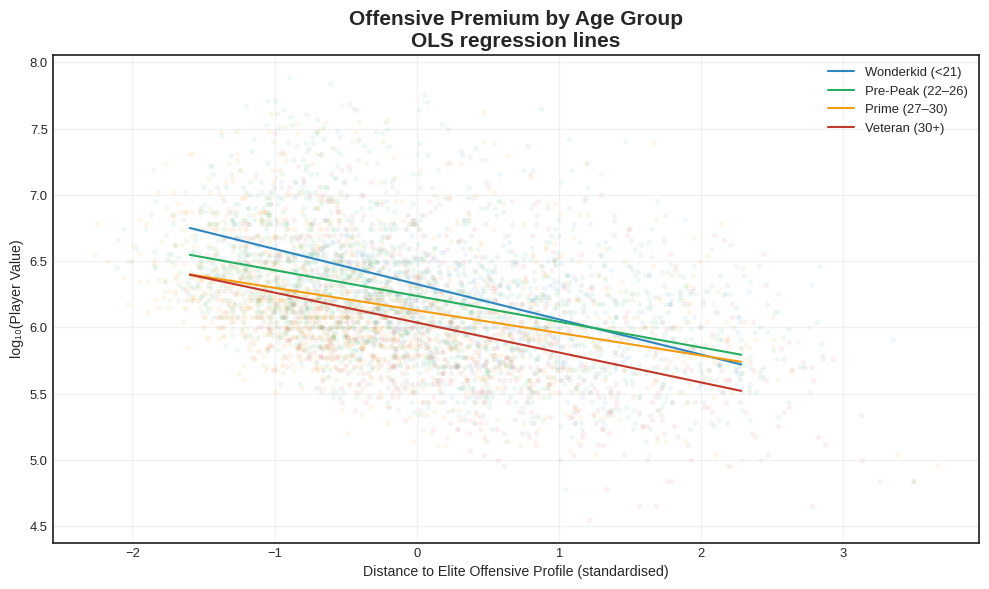


REGRESSION RESULTS BY AGE GROUP
       Age Group    n  Coefficient    SE    R²  Multiplier (per SD)
 Wonderkid (<21)  578       -0.266 0.019 0.262                1.844
   Veteran (30+)  920       -0.226 0.015 0.201                1.683
Pre-Peak (22–26) 1670       -0.194 0.010 0.177                1.565
   Prime (27–30) 1379       -0.170 0.011 0.140                1.480


In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --------------------------------------------------
# AGE GROUPS
# --------------------------------------------------

def categorize_age(age):
    if age <= 21:
        return 'Wonderkid (<21)'
    elif age <= 26:
        return 'Pre-Peak (22–26)'
    elif age <= 30:
        return 'Prime (27–30)'
    else:
        return 'Veteran (30+)'

df = analysis_df.copy()

df["age_group"] = df["age"].apply(categorize_age)
df["log_value"] = np.log10(df["value_eur"])

df["dist_scaled"] = (
    df["dist_to_offensive_star"]
    - df["dist_to_offensive_star"].mean()
) / df["dist_to_offensive_star"].std()

age_groups = [
    "Wonderkid (<21)",
    "Pre-Peak (22–26)",
    "Prime (27–30)",
    "Veteran (30+)"
]

colors = {
    "Wonderkid (<21)": "#2E86C1",
    "Pre-Peak (22–26)": "#27AE60",
    "Prime (27–30)": "#F39C12",
    "Veteran (30+)": "#C0392B"
}

# --------------------------------------------------
# PLOT
# --------------------------------------------------

plt.figure(figsize=(10, 6))

x_grid = np.linspace(
    df["dist_scaled"].quantile(0.02),
    df["dist_scaled"].quantile(0.98),
    200
)

results = []

for age in age_groups:

    sub = df[df["age_group"] == age]

    # regression
    X = sm.add_constant(sub["dist_scaled"])
    y = sub["log_value"]
    model = sm.OLS(y, X).fit()

    # prediction
    y_hat = model.predict(
        sm.add_constant(x_grid)
    )

    # scatter (very light)
    plt.scatter(
        sub["dist_scaled"],
        sub["log_value"],
        s=8,
        alpha=0.05,
        color=colors[age]
    )

    # regression line
    plt.plot(
        x_grid,
        y_hat,
        linewidth=1.5,
        color=colors[age],
        label=f"{age}"
    )

    results.append({
        "Age Group": age,
        "n": len(sub),
        "Coefficient": model.params["dist_scaled"],
        "SE": model.bse["dist_scaled"],
        "R²": model.rsquared,
        "Multiplier (per SD)": 10 ** (-model.params["dist_scaled"])
    })

# --------------------------------------------------
# FORMATTING
# --------------------------------------------------

plt.xlabel("Distance to Elite Offensive Profile (standardised)")
plt.ylabel("log₁₀(Player Value)")
plt.title(
    "Offensive Premium by Age Group\nOLS regression lines",
    fontsize=15,
    fontweight="bold"
)

plt.legend(frameon=False)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# COEFFICIENT TABLE (OUTSIDE PLOT)
# --------------------------------------------------

coef_table = (
    pd.DataFrame(results)
    .round(3)
    .sort_values("Coefficient")
)

print("\n" + "=" * 80)
print("REGRESSION RESULTS BY AGE GROUP")
print("=" * 80)
print(coef_table.to_string(index=False))


# **Do leagues price this profile differently?**

Players in top 5 leagues: 598

Breakdown:
league_name
French Ligue 1            143
Italian Serie A           127
Spain Primera Division    115
German 1. Bundesliga      112
English Premier League    101
Name: count, dtype: int64


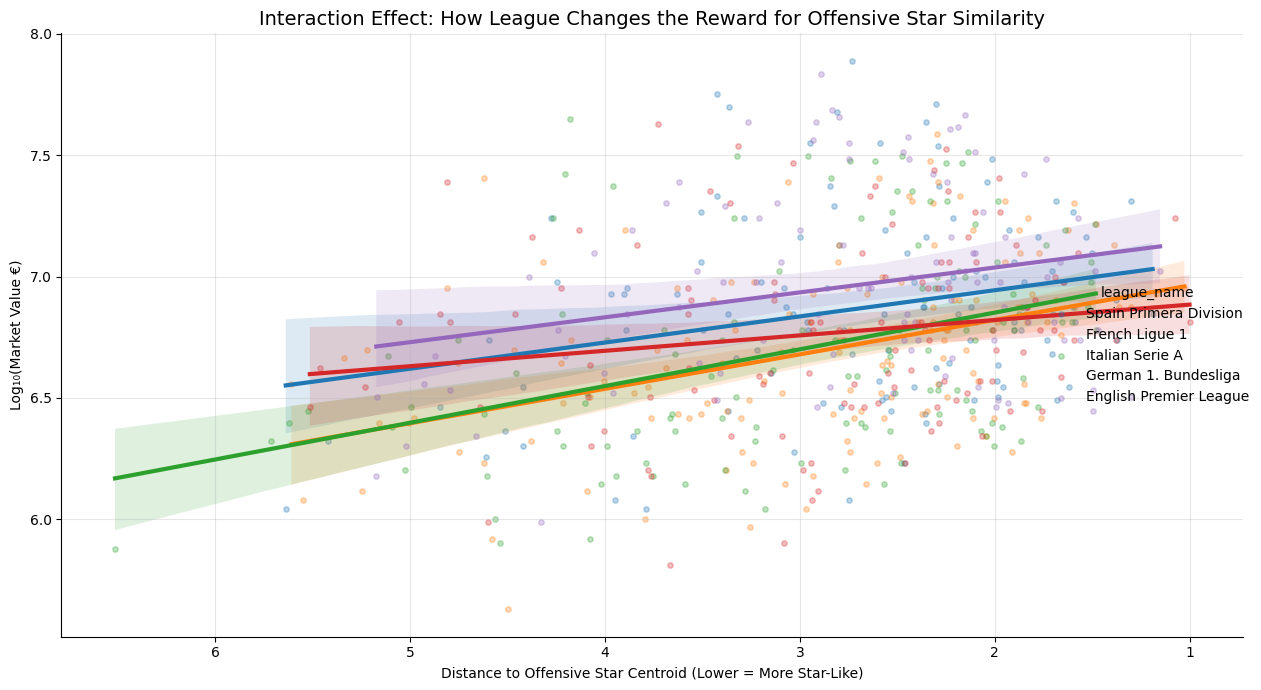


Correlation between offensive-star proximity and value by league:

league_name
French Ligue 1           -0.396231
Italian Serie A          -0.381813
Spain Primera Division   -0.252337
English Premier League   -0.250429
German 1. Bundesliga     -0.163261
Name: corr(dist_to_off_star, log_value), dtype: float64


In [119]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define top 5 leagues (adjust Premier League name as needed)
top_5_leagues = [
    'Spain Primera Division',
    'German 1. Bundesliga',
    'Italian Serie A',
    'French Ligue 1',
    'English Premier League'  # UPDATE THIS based on output above
]

# Filter to top 5 leagues only
df_top5 = analysis_df[analysis_df['league_name'].isin(top_5_leagues)].copy()
df_top5['log_value'] = np.log10(df_top5['value_eur'])

print(f"Players in top 5 leagues: {len(df_top5)}")
print(f"\nBreakdown:")
print(df_top5['league_name'].value_counts())

# Visualise interaction: league × offensive-star proximity
sns.lmplot(
    data=df_top5,
    x='dist_to_offensive_star',
    y='log_value',
    hue='league_name',
    height=7,
    aspect=1.5,
    scatter_kws={'alpha': 0.3, 's': 15},
    line_kws={'linewidth': 3}
)

plt.xlabel('Distance to Offensive Star Centroid (Lower = More Star-Like)')
plt.ylabel('Log₁₀(Market Value €)')
plt.title('Interaction Effect: How League Changes the Reward for Offensive Star Similarity',
          fontsize=14)
plt.gca().invert_xaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Quantify the relationship by league
print("\nCorrelation between offensive-star proximity and value by league:\n")

league_corrs = (
    df_top5
    .groupby('league_name')
    .apply(lambda g: g['dist_to_offensive_star'].corr(g['log_value']), include_groups=False)
    .rename('corr(dist_to_off_star, log_value)')
    .sort_values()
)

print(league_corrs)

In [125]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# Filter to top 5 only
top_5_leagues = [
    'Spain Primera Division',
    'German 1. Bundesliga',
    'Italian Serie A',
    'French Ligue 1',
    'English Premier League'
]

df_top5 = analysis_df[analysis_df['league_name'].isin(top_5_leagues)].copy()
df_top5['log_value'] = np.log10(df_top5['value_eur'])

# Standardise distance
df_top5['dist_scaled'] = (
    df_top5['dist_to_offensive_star'] - df_top5['dist_to_offensive_star'].mean()
) / df_top5['dist_to_offensive_star'].std()

print("=" * 60)
print("SAMPLE SIZES BY LEAGUE")
print("=" * 60)
print(df_top5['league_name'].value_counts())

# Run separate regressions per league
print("\n" + "=" * 60)
print("REGRESSION BY LEAGUE")
print("=" * 60)

results = []
for league in top_5_leagues:
    league_df = df_top5[df_top5['league_name'] == league]
    X = sm.add_constant(league_df['dist_scaled'])
    y = league_df['log_value']
    model = sm.OLS(y, X).fit()
    
    multiplier = 10 ** (-model.params['dist_scaled'])
    results.append({
        'League': league,
        'n': len(league_df),
        'Coefficient': model.params['dist_scaled'],
        'SE': model.bse['dist_scaled'],
        'R²': model.rsquared,
        'Multiplier': multiplier
    })
    
    print(f"\n{league}:")
    print(f"  n = {len(league_df)}")
    print(f"  Coefficient: {model.params['dist_scaled']:.4f} (SE: {model.bse['dist_scaled']:.4f})")
    print(f"  R-squared: {model.rsquared:.3f}")
    print(f"  Multiplier per SD: {multiplier:.2f}x")

# Test for differences using interaction model within top 5
print("\n" + "=" * 60)
print("TESTING DIFFERENCES BETWEEN LEAGUES")
print("=" * 60)

# Create dummies as float
dummies = pd.get_dummies(df_top5['league_name'], drop_first=True, dtype=float)
dummy_cols = dummies.columns.tolist()

# Add to dataframe
for col in dummy_cols:
    df_top5[col] = dummies[col].values

# Create interactions
interaction_cols = []
for col in dummy_cols:
    interact_name = f'{col}_x_dist'
    df_top5[interact_name] = df_top5[col] * df_top5['dist_scaled']
    interaction_cols.append(interact_name)

# Full interaction model
X_full = sm.add_constant(df_top5[['dist_scaled'] + dummy_cols + interaction_cols].astype(float))
y_full = df_top5['log_value']
model_full = sm.OLS(y_full, X_full).fit()

# Reduced model (no interactions)
X_reduced = sm.add_constant(df_top5[['dist_scaled'] + dummy_cols].astype(float))
model_reduced = sm.OLS(y_full, X_reduced).fit()

# F-test for interaction terms
f_stat = ((model_reduced.ssr - model_full.ssr) / len(interaction_cols)) / (model_full.ssr / model_full.df_resid)
p_value = 1 - stats.f.cdf(f_stat, len(interaction_cols), model_full.df_resid)

print(f"\nF-test for league interaction effects:")
print(f"  F-statistic: {f_stat:.3f}")
print(f"  P-value: {p_value:.6f}")

if p_value < 0.05:
    print("\n✓ Significant differences exist between leagues (p < 0.05)")
else:
    print("\n✗ No significant differences between leagues (p >= 0.05)")

# Summary table
print("\n" + "=" * 60)
print("SUMMARY: Offensive Premium by League")
print("=" * 60)
results_df = pd.DataFrame(results).sort_values('Coefficient')
print(results_df.to_string(index=False))

SAMPLE SIZES BY LEAGUE
league_name
French Ligue 1            143
Italian Serie A           127
Spain Primera Division    115
German 1. Bundesliga      112
English Premier League    101
Name: count, dtype: int64

REGRESSION BY LEAGUE

Spain Primera Division:
  n = 115
  Coefficient: -0.1074 (SE: 0.0387)
  R-squared: 0.064
  Multiplier per SD: 1.28x

German 1. Bundesliga:
  n = 112
  Coefficient: -0.0632 (SE: 0.0364)
  R-squared: 0.027
  Multiplier per SD: 1.16x

Italian Serie A:
  n = 127
  Coefficient: -0.1508 (SE: 0.0326)
  R-squared: 0.146
  Multiplier per SD: 1.42x

French Ligue 1:
  n = 143
  Coefficient: -0.1414 (SE: 0.0276)
  R-squared: 0.157
  Multiplier per SD: 1.38x

English Premier League:
  n = 101
  Coefficient: -0.1022 (SE: 0.0397)
  R-squared: 0.063
  Multiplier per SD: 1.27x

TESTING DIFFERENCES BETWEEN LEAGUES

F-test for league interaction effects:
  F-statistic: 1.059
  P-value: 0.376106

✗ No significant differences between leagues (p >= 0.05)

SUMMARY: Offensive Pre

## Robustness Check: Does the Offensive Premium Vary by League?

We tested whether the offensive premium differs across the top 5 European leagues.

### Results by League

| League | n | Multiplier per SD | R² |
|--------|---|-------------------|-----|
| Italian Serie A | 127 | 1.42x | 15% |
| French Ligue 1 | 143 | 1.38x | 16% |
| Spain Primera Division | 115 | 1.28x | 6% |
| English Premier League | 101 | 1.27x | 6% |
| German Bundesliga | 112 | 1.16x | 3% |

### Statistical Test

**F-test for interaction effects:** F = 1.06, p = 0.38

**Result:** No significant differences between leagues.

### Interpretation

While point estimates vary (Italy 1.42x vs Germany 1.16x), this variation is **not statistically distinguishable from sampling noise** given sample sizes of ~100-140 players per league.

The offensive premium is **consistent across elite leagues** — the market applies the same valuation logic regardless of league. This suggests pricing efficiency: there's no systematic arbitrage opportunity where offensive players are undervalued in one league relative to another.

# **Exploring where defender value comes from** 



In [130]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Filter to defenders only
df_def = analysis_df[analysis_df['formation'] == 'def'].copy()
df_def['log_value'] = np.log10(df_def['value_eur'])

print(f"Defenders in sample: {len(df_def)}")

# Base features to test
base_features = [
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'age', 'height_cm', 'weight_kg'
]

# Add our distance metrics
distance_features = ['dist_to_offensive_star', 'dist_to_defensive_star']

all_features = base_features + distance_features

# Correlation with log value for defenders
print("\n" + "=" * 60)
print("WHAT DRIVES DEFENDER VALUE?")
print("=" * 60)
print("\nCorrelations with log(value) for DEFENDERS only:\n")

corrs = df_def[all_features + ['log_value']].corr()['log_value'].drop('log_value').sort_values()
print(corrs.round(3).to_string())

# Standardise features for regression
df_def_scaled = df_def.copy()
for feat in base_features:
    df_def_scaled[f'{feat}_scaled'] = (
        df_def_scaled[feat] - df_def_scaled[feat].mean()
    ) / df_def_scaled[feat].std()

# Run multivariate regression for defenders
print("\n" + "=" * 60)
print("MULTIVARIATE REGRESSION: Defender Value")
print("=" * 60)

scaled_features = [f'{feat}_scaled' for feat in base_features]
X = sm.add_constant(df_def_scaled[scaled_features].astype(float))
y = df_def_scaled['log_value']

model = sm.OLS(y, X).fit()
print(model.summary())

# Extract coefficients and sort by absolute value
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE FOR DEFENDERS (by coefficient magnitude)")
print("=" * 60)

coef_df = pd.DataFrame({
    'Feature': base_features,
    'Coefficient': [model.params[f'{feat}_scaled'] for feat in base_features],
    'P-value': [model.pvalues[f'{feat}_scaled'] for feat in base_features],
    'Multiplier': [10 ** (-model.params[f'{feat}_scaled']) for feat in base_features]
}).sort_values('Coefficient')

print(coef_df.to_string(index=False))

# Compare to attackers
print("\n" + "=" * 60)
print("COMPARISON: What drives value for ATTACKERS?")
print("=" * 60)

df_att = analysis_df[analysis_df['formation'] == 'att'].copy()
df_att['log_value'] = np.log10(df_att['value_eur'])

for feat in base_features:
    df_att[f'{feat}_scaled'] = (
        df_att[feat] - df_att[feat].mean()
    ) / df_att[feat].std()

X_att = sm.add_constant(df_att[[f'{feat}_scaled' for feat in base_features]].astype(float))
y_att = df_att['log_value']
model_att = sm.OLS(y_att, X_att).fit()

coef_att = pd.DataFrame({
    'Feature': base_features,
    'Def_Coef': [model.params[f'{feat}_scaled'] for feat in base_features],
    'Att_Coef': [model_att.params[f'{feat}_scaled'] for feat in base_features],
}).sort_values('Def_Coef')

print(coef_att.to_string(index=False))

Defenders in sample: 1892

WHAT DRIVES DEFENDER VALUE?

Correlations with log(value) for DEFENDERS only:

dist_to_offensive_star   -0.626
dist_to_defensive_star   -0.271
age                      -0.220
weight_kg                 0.063
height_cm                 0.080
pace                      0.271
shooting                  0.290
physic                    0.392
passing                   0.513
dribbling                 0.529
defending                 0.731

MULTIVARIATE REGRESSION: Defender Value
                            OLS Regression Results                            
Dep. Variable:              log_value   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1429.
Date:                Sat, 17 Jan 2026   Prob (F-statistic):               0.00
Time:                        01:16:43   Log-Likelihood:                 676.75
No. Observations:          

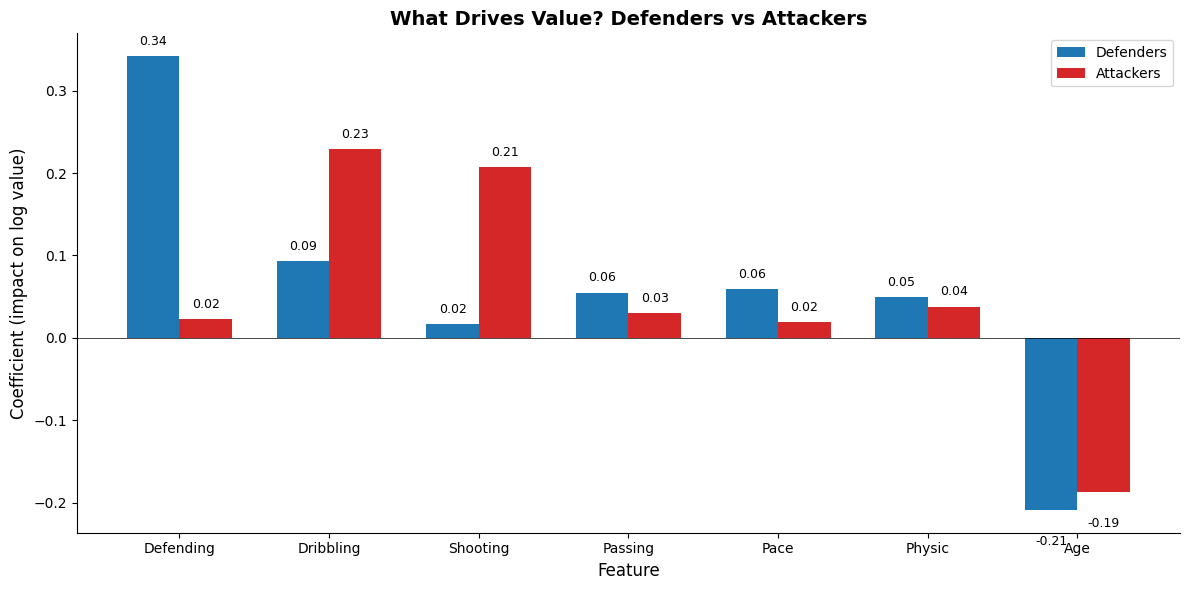

KEY INSIGHT

DEFENDERS: Defending (0.34) >> Dribbling (0.09) >> Pace (0.06)
ATTACKERS: Dribbling (0.23) ≈ Shooting (0.21) >> everything else

The market values DIFFERENT skills for different positions.
But within defenders, it wants MODERN defenders:
  - High defending skill
  - Ball-playing ability (dribbling, passing)
  - Pace for recovery
  
NOT traditional defenders:
  - Height (0.00 effect)
  - Weight (0.00 effect)  
  - Physic (0.05 effect — minimal)



In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Side-by-side coefficient comparison: Defenders vs Attackers
fig, ax = plt.subplots(figsize=(12, 6))

features = ['defending', 'dribbling', 'shooting', 'passing', 'pace', 'physic', 'age']
def_coefs = [0.342, 0.093, 0.017, 0.055, 0.059, 0.049, -0.209]
att_coefs = [0.023, 0.229, 0.207, 0.030, 0.019, 0.038, -0.187]

x = np.arange(len(features))
width = 0.35

bars1 = ax.bar(x - width/2, def_coefs, width, label='Defenders', color='#1f77b4')
bars2 = ax.bar(x + width/2, att_coefs, width, label='Attackers', color='#d62728')

ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Coefficient (impact on log value)', fontsize=12)
ax.set_title('What Drives Value? Defenders vs Attackers', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f.capitalize() for f in features])
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01 if height >= 0 else height - 0.03,
            f'{height:.2f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01 if height >= 0 else height - 0.03,
            f'{height:.2f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print the key insight
print("=" * 60)
print("KEY INSIGHT")
print("=" * 60)
print("""
DEFENDERS: Defending (0.34) >> Dribbling (0.09) >> Pace (0.06)
ATTACKERS: Dribbling (0.23) ≈ Shooting (0.21) >> everything else

The market values DIFFERENT skills for different positions.
But within defenders, it wants MODERN defenders:
  - High defending skill
  - Ball-playing ability (dribbling, passing)
  - Pace for recovery
  
NOT traditional defenders:
  - Height (0.00 effect)
  - Weight (0.00 effect)  
  - Physic (0.05 effect — minimal)
""")

Defending is the single biggest driver of defender value — but the market bundles offensive traits together, so a 'ball-playing' defender with good-not-great defending outearns a defensive specialist. That's where the arbitrage lives

### **BIAS CHECK: Are stars just players in rich leagues?**

To test whether star tagging simply reflects league-level bias or data availability, I estimated a logistic regression where the probability of being tagged a star is explained jointly by player attributes and league fixed effects. In this setup, each league coefficient measures whether players in that league are more likely to be tagged as stars *holding skill constant*.

The results show that star tagging is primarily driven by observable player characteristics—most notably overall quality, physicality, pace, and role-related attributes—while league effects are generally small, inconsistent in sign, and often statistically insignificant. Major European leagues do not exhibit a uniform positive effect once skills are controlled for. Apparent extreme league coefficients arise from perfect separation in very small leagues and reflect data sparsity rather than systematic bias.

Overall, this indicates that stars are concentrated in elite leagues due to talent sorting, not because league affiliation mechanically increases the likelihood of being tagged. The star clusters therefore reflect genuine skill archetypes rather than geographic or data-coverage artefacts.



In [15]:
import statsmodels.api as sm
import numpy as np

skill_features = [
    'dribbling', 'passing', 'shooting', 'pace',
    'physic', 'defending'
]

# Build X cleanly
X = outfield_df[skill_features].copy()

league_dummies = pd.get_dummies(
    outfield_df['league_name'],
    drop_first=True,
    dtype=float
)

X = pd.concat([X, league_dummies], axis=1)

# Dependent variable
y = outfield_df['is_star']

# Drop rows with any missing data
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask]
y = y.loc[mask]
# Add constant and force numeric
X = sm.add_constant(X)
X = X.astype(float)
y = y.astype(int)

# Fit logit
model = sm.Logit(y, X).fit(disp=False)
print(model.summary())


/home/david/Uni/Visa_Case/.venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/david/Uni/Visa_Case/.venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix